In [2]:
import os, sys
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="1" 
import keras
import sent2vec
import seq2seq
from seq2seq.models import AttentionSeq2Seq
from seq2seq.models import Seq2Seq
from keras.utils import multi_gpu_model
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import pickle
import tqdm
from tqdm import tqdm

import xlsxwriter
import numpy as np
from random import shuffle
from math import log, floor
import pandas as pd
import tensorflow as tf
import tensorboard as tb
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.utils import *
from keras.layers.advanced_activations import *
from keras import *
from keras.engine.topology import *
from keras.optimizers import *
import gensim
from gensim.models.word2vec import *
from keras.preprocessing.text import *
from keras.preprocessing.sequence import *
from keras.utils import *
from sklearn.model_selection import *
import random
from random import shuffle
import re
from collections import Counter
from keras.utils.generic_utils import *
from keras import regularizers
import string
import unicodedata as udata
import pickle
from keras.applications import *
from keras.preprocessing.image import *
import pause, datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_enc = pickle.load(open('output/api_enc2.pkl','rb'))
df_enc

,BOS,CopyFile,CreateFile,CreateProcess,CreateRemoteThread,CreateThread,DeleteFile,EOS,ExitProcess,GetUrlCacheEntryInfo,...,RegQueryValue,RegSetValue,TerminateProcess,WinExec,WinHttpConnect,WinHttpOpen,WinHttpOpenRequest,WinHttpReadData,WinHttpSendRequest,WinHttpWriteData
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
model = sent2vec.Sent2vecModel()
model.load_model('model/sent2vec_sentences_rep_0117.bin')
all_tree_name = pickle.load(open('output/tree_name.pkl','rb'))

In [4]:
%run MotifAnalysis/Hooklog3.ipynb
Hooklog = Hooklog3

## get each hooklog's trainX

## combine all train data to 3D array
* trainX: (N,upper_bound,api_dim+param_dim)
* trainY2: (N,upper_bound_rep,api_dim+param_dim)

=>以下挑一個

original api+param(含api)

In [80]:
root_dir = './data/tree-rep-logs-profile/'
out_dir = './data/tree-rep-logs-profile/'
lower_bound = 8 #10%
upper_bound = 498 #90%
window_size = 8
upper_bound_rep = 502 #debug max_size #q2~q3:167 #10%(8)~90%(498):502

max_size = 0
families=[]
tree_min = 3 #tree要多於幾個就要抓進去test跟valid?
train_fam={}
valid_fam={}
test_fam={}
trees=[]
pad_npy = df_enc['<PAD>'].values
pad_npy = np.expand_dims(pad_npy,axis=0)
pad_npy_param = model.embed_sentence(' <PAD>'*window_size)
dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
# in_parseFirstPar=False
trainX=[]
validX=[]
testX=[]
trainY=[]
validY=[]
testY=[]
fam_dir = next(os.walk(root_dir))[1]
train_fam = train_fam.fromkeys(fam_dir,0) #fam_dir all_tree_name
valid_fam = valid_fam.fromkeys(fam_dir,0)#fam_dir all_tree_name
test_fam = test_fam.fromkeys(fam_dir,0)#fam_dir all_tree_name
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        out_directory = out_dir + fam + '/' + tree + '/'
        if not os.path.exists(out_directory):
            os.makedirs(out_directory)
        hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
        hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list
        hl_list = list(filter(lambda f: f.endswith(".hooklog"), hl_list))
        if len(hl_list)>=tree_min: #tree大於幾個就要抓去valid跟test?
            v_c = "valid"
        else:
            v_c = 0
        for hkl in hl_list:
            param = []
            with open(hkl , encoding='ISO 8859-1') as f:
                profile = f.read().splitlines()
            if (len(profile)<lower_bound or len(profile)>upper_bound):
                continue
            else:
                    
                for line in profile:
                    temp = re.sub(dil," ",line)
                    temp = temp.replace('PR','')
                    temp = temp.replace('Ret','')
                    temp = temp.replace('SUBK','')
                    temp = temp.split(" ")
                    temp = list(filter(None, temp))
                    temp = ' '.join(temp)
                    temp = model.embed_sentence(temp) #(132,)
                    temp = np.squeeze(temp)
                    param.append(temp)
                param = np.array(param) #(length,132)
                profile = [i.split('#PR')[0] for i in profile]
                try:
                    profile = np.array([df_enc[i] for i in profile]) #(legth,32)
                except:
                    profile = [i.split('#Ret')[0] for i in profile] #WinHttpSendRequest
                    profile = np.array([df_enc[i] for i in profile])
#                 profile = np.concatenate((profile,param),axis=1)
                size = len(profile)
                if size<upper_bound:
                    for _ in range(upper_bound - size):
                        profile = np.append(profile,pad_npy,axis=0) #(upper,32)
                        param = np.append(param,pad_npy_param,axis=0)
                profile = np.concatenate((profile,param),axis=1)
                if v_c=="valid":
                    validX.append(profile)
                    valid_fam[fam]+=1 #+tree
                    ch = len(validX)
                    v_c='valid'
#                     print("VX:",fam,tree,ch)
                elif v_c=="test":
                    testX.append(profile)
                    test_fam[fam]+=1 #+tree
                    v_c='test'
#                     print("TX",fam,tree)
                else:
                    trainX.append(profile)
                    train_fam[fam]+=1 #+tree
                
                #trainY2 rep
                rep_api = pickle.load(open(in_directory+'api_name.pickle','rb')) #(length,32)
                rep_param = pickle.load(open(in_directory+'parameter_rep.pickle','rb'))
                
                param=[]
                for line in rep_param:
                    temp = re.sub(dil," ",line)
                    temp = temp.replace('PR','')
                    temp = temp.replace('Ret','')
                    temp = temp.replace('SUBK','')
                    temp = temp.split(" ")
                    temp = list(filter(None, temp))
                    temp = ' '.join(temp)
                    temp = model.embed_sentence(temp) #(132,)
                    temp = np.squeeze(temp)
                    param.append(temp)
                param = np.array(param)
                size_ = len(rep_api)
#                 if size_ > upper_bound:
#                     print(in_directory,size_)
                if size_ > max_size: #test
                    max_size = size_
                if in_directory.split('/')[3] not in families:
                    families.append(in_directory.split('/')[3])
                if in_directory.split('/')[3] + in_directory.split('/')[4] not in trees:
                    trees.append(in_directory.split('/')[3] + in_directory.split('/')[4])
                    
#                     continue #debug
#                 break #debug
                if size_ < upper_bound_rep:
                    for _ in range(upper_bound_rep - size_):
                        rep_api = np.append(rep_api,pad_npy,axis=0)
                        param = np.append(param,pad_npy_param,axis=0)
#                 print(rep_api.shape , param.shape)
                rep_api = np.concatenate((rep_api,param),axis=1)
                if v_c=="valid":
                    validY.append(rep_api)
                    v_c="test"
#                     print("VY",fam,tree)
                elif v_c=="test":
                    testY.append(rep_api)
                    v_c=0
#                     if ch != len(testY):
#                         print("TY:",fam,tree, len(testY))
                else:
                    trainY.append(rep_api)
#                 if ch != len(testY):
#                     print(fam,tree,ch,len(testY))
trainX = np.array(trainX)
validX = np.array(validX)
testX = np.array(testX)
trainY2 = np.array(trainY)
validY2 = np.array(validY)
testY2 = np.array(testY)
print(trainX.shape,validX.shape, testX.shape)
print(trainY2.shape,validY2.shape,testY2.shape)
#             break #debug




  0%|          | 0/80 [00:00<?, ?it/s]

crytex_0.8 G47 577 0
crytex_0.8 G47 577 0
crytex_0.8 G52 1 0
crytex_0.8 G53 2 1


  1%|▏         | 1/80 [00:01<01:48,  1.37s/it]

symmi_0.8 G303 3 2
symmi_0.8 G317 4 3
symmi_0.8 G311 5 4
symmi_0.8 G312 6 5
symmi_0.8 G308 7 6
symmi_0.8 G313 8 7
symmi_0.8 G306 9 8
symmi_0.8 G253 10 9
symmi_0.8 G307 11 10
symmi_0.8 G316 12 11
symmi_0.8 G318 13 12
symmi_0.8 G300 14 13
symmi_0.8 G301 15 14


  2%|▎         | 2/80 [00:05<03:43,  2.87s/it]

symmi_0.8 G304 16 15
chir_0.8 G65 17 16
chir_0.8 G67 18 17


  4%|▍         | 3/80 [00:06<02:44,  2.13s/it]

chir_0.8 G63 19 18
elkern_0.8 G203 20 19
elkern_0.8 G229 21 20
elkern_0.8 G193 22 21
elkern_0.8 G188 23 22


  5%|▌         | 4/80 [00:13<04:18,  3.40s/it]

elkern_0.8 G220 24 23
virut_0.8 G1304 25 24
virut_0.8 G1308 26 25
virut_0.8 G1278 27 26
virut_0.8 G1316 28 27
virut_0.8 G1264 29 28
virut_0.8 G1201 30 29
virut_0.8 G1327 31 30
virut_0.8 G1036 32 31
virut_0.8 G1233 33 32
virut_0.8 G1324 34 33
virut_0.8 G1295 35 34
virut_0.8 G985 36 35
virut_0.8 G1323 37 36
virut_0.8 G1315 38 37
virut_0.8 G1331 39 38
virut_0.8 G1212 40 39
virut_0.8 G1220 41 40
virut_0.8 G1271 42 41
virut_0.8 G1035 43 42
virut_0.8 G1310 44 43
virut_0.8 G1231 45 44
virut_0.8 G954 46 45
virut_0.8 G1285 47 46
virut_0.8 G998 48 47
virut_0.8 G1235 49 48
virut_0.8 G1270 50 49
virut_0.8 G1317 51 50
virut_0.8 G1216 52 51
virut_0.8 G1238 53 52
virut_0.8 G1299 54 53
virut_0.8 G1002 55 54
virut_0.8 G1305 56 55
virut_0.8 G1024 57 56
virut_0.8 G1274 58 57
virut_0.8 G960 59 58
virut_0.8 G1314 60 59
virut_0.8 G981 61 60
virut_0.8 G987 62 61
virut_0.8 G1273 63 62
virut_0.8 G1309 64 63
virut_0.8 G1279 65 64
virut_0.8 G1266 66 65
virut_0.8 G973 67 66
virut_0.8 G969 68 67
virut_0.8 G1262 69

  6%|▋         | 5/80 [00:40<10:14,  8.19s/it]

virut_0.8 G1217 93 92
graftor_0.8 G303 94 93
graftor_0.8 G297 95 94
graftor_0.8 G276 95 94
graftor_0.8 G276 95 94
graftor_0.8 G294 96 94
graftor_0.8 G294 96 95
graftor_0.8 G294 96 95
graftor_0.8 G294 96 95
graftor_0.8 G294 96 95
graftor_0.8 G229 96 95
graftor_0.8 G229 96 95
graftor_0.8 G234 96 95
graftor_0.8 G234 96 95
graftor_0.8 G271 96 95
graftor_0.8 G271 96 95
graftor_0.8 G299 97 95
graftor_0.8 G299 97 96
graftor_0.8 G299 97 96
graftor_0.8 G299 97 96
graftor_0.8 G299 97 96
graftor_0.8 G299 97 96
graftor_0.8 G299 97 96
graftor_0.8 G299 97 96
graftor_0.8 G299 97 96
graftor_0.8 G282 98 96
graftor_0.8 G282 98 97
graftor_0.8 G282 98 97
graftor_0.8 G290 99 97
graftor_0.8 G290 99 98
graftor_0.8 G290 99 98
graftor_0.8 G290 99 98
graftor_0.8 G290 99 98
graftor_0.8 G290 99 98
graftor_0.8 G265 99 98
graftor_0.8 G265 99 98
graftor_0.8 G255 99 98
graftor_0.8 G255 99 98
graftor_0.8 G259 99 98
graftor_0.8 G259 99 98
graftor_0.8 G236 100 98
graftor_0.8 G236 100 99
graftor_0.8 G236 100 99
graftor_0

  8%|▊         | 6/80 [00:45<09:23,  7.61s/it]

graftor_0.8 G238 105 104
graftor_0.8 G238 105 104
eggnog_0.8 G114 106 104
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G114 106 105
eggnog_0.8 G11

  9%|▉         | 7/80 [00:48<08:28,  6.97s/it]

eggnog_0.8 G92 106 105
eggnog_0.8 G92 106 105
onlinegames_0.8 G38 106 105
onlinegames_0.8 G38 106 105
onlinegames_0.8 G40 107 105
onlinegames_0.8 G40 107 106
onlinegames_0.8 G40 107 106
onlinegames_0.8 G34 107 106
onlinegames_0.8 G34 107 106
onlinegames_0.8 G41 108 106
onlinegames_0.8 G41 108 107
onlinegames_0.8 G41 108 107
onlinegames_0.8 G42 109 107
onlinegames_0.8 G42 109 108
onlinegames_0.8 G42 109 108


 10%|█         | 8/80 [00:50<07:31,  6.28s/it]

onlinegames_0.8 G42 109 108
onlinegames_0.8 G42 109 108
strictor_0.8 G143 110 108
strictor_0.8 G143 110 109
strictor_0.8 G143 110 109
strictor_0.8 G143 110 109
strictor_0.8 G138 110 109
strictor_0.8 G138 110 109
strictor_0.8 G135 110 109
strictor_0.8 G135 110 109
strictor_0.8 G142 111 109
strictor_0.8 G142 111 110
strictor_0.8 G142 111 110
strictor_0.8 G124 111 110
strictor_0.8 G124 111 110
strictor_0.8 G118 111 110
strictor_0.8 G118 111 110
strictor_0.8 G133 111 110
strictor_0.8 G133 111 110
strictor_0.8 G131 111 110
strictor_0.8 G131 111 110
strictor_0.8 G123 111 110
strictor_0.8 G123 111 110
strictor_0.8 G141 112 110
strictor_0.8 G141 112 111
strictor_0.8 G141 112 111
strictor_0.8 G141 112 111
strictor_0.8 G126 112 111
strictor_0.8 G126 112 111
strictor_0.8 G125 112 111
strictor_0.8 G125 112 111
strictor_0.8 G137 112 111
strictor_0.8 G137 112 111
strictor_0.8 G122 112 111


 11%|█▏        | 9/80 [00:52<06:50,  5.78s/it]

strictor_0.8 G122 112 111
razy_0.8 G114 112 111
razy_0.8 G114 112 111
razy_0.8 G118 112 111
razy_0.8 G118 112 111
razy_0.8 G133 113 111
razy_0.8 G133 113 112
razy_0.8 G133 113 112
razy_0.8 G133 113 112
razy_0.8 G133 113 112
razy_0.8 G133 113 112
razy_0.8 G133 113 112
razy_0.8 G133 113 112
razy_0.8 G133 113 112
razy_0.8 G133 113 112
razy_0.8 G131 114 112
razy_0.8 G131 114 113
razy_0.8 G131 114 113
razy_0.8 G128 115 113
razy_0.8 G128 115 114
razy_0.8 G128 115 114
razy_0.8 G130 116 114
razy_0.8 G130 116 115
razy_0.8 G130 116 115
razy_0.8 G126 116 115
razy_0.8 G126 116 115
razy_0.8 G137 117 115
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G137 117 116
razy_0.8 G122 117 116
razy_0.8 G122 117 116
razy_0.8 G120 117 116
razy_0.8 G120 117 116
razy_0.8 G134 118 116
razy_0.8 G134 118 117
razy_0.8 G134 118 117
razy_0

 12%|█▎        | 10/80 [00:54<06:19,  5.42s/it]

razy_0.8 G134 118 117
razy_0.8 G134 118 117
razy_0.8 G134 118 117
razy_0.8 G134 118 117
razy_0.8 G134 118 117
zbot_0.8 G476 119 117
zbot_0.8 G476 119 118
zbot_0.8 G476 119 118
zbot_0.8 G495 120 118
zbot_0.8 G422 120 118
zbot_0.8 G422 120 118
zbot_0.8 G453 120 118
zbot_0.8 G453 120 118
zbot_0.8 G470 121 118
zbot_0.8 G470 121 119
zbot_0.8 G470 121 119
zbot_0.8 G470 121 119
zbot_0.8 G379 122 119
zbot_0.8 G379 122 120
zbot_0.8 G379 122 120
zbot_0.8 G379 122 120
zbot_0.8 G487 123 120
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G487 123 121
zbot_0.8 G384 123 121
zbot_0.8 G384 123 121
zbot_0.8 G450 123 121
zbot_0.8 G450 123 121
zbot_0.8 G399 123 121
zbot_0.8 G399 123 121
zbot_0.8 G490 124 121
zbot_0.8 G490 124 122
zbot_0.8 G490 124 122
zbot_0.8 G490 124 122
zbot_0.8 G490 124 122
zbot_0.8 G490 124 122
zbot_0.8 G418 124 122
zbot_0.8 G

 14%|█▍        | 11/80 [01:03<06:40,  5.81s/it]

zbot_0.8 G460 144 141
bundlore_0.8 G50 144 141
bundlore_0.8 G50 144 141
bundlore_0.8 G47 144 141
bundlore_0.8 G47 144 141
bundlore_0.8 G44 144 141
bundlore_0.8 G44 144 141
bundlore_0.8 G43 144 141
bundlore_0.8 G43 144 141
bundlore_0.8 G45 144 141


 15%|█▌        | 12/80 [01:05<06:08,  5.42s/it]

bundlore_0.8 G45 144 141
bundlore_0.8 G48 144 141
bundlore_0.8 G48 144 141
installrex_0.8 G72 145 141
installrex_0.8 G72 145 142
installrex_0.8 G72 145 142
installrex_0.8 G72 145 142
installrex_0.8 G72 145 142
installrex_0.8 G70 146 142
installrex_0.8 G70 146 143
installrex_0.8 G70 146 143
installrex_0.8 G67 146 143
installrex_0.8 G67 146 143
installrex_0.8 G59 146 143
installrex_0.8 G59 146 143
installrex_0.8 G73 147 143
installrex_0.8 G73 147 144
installrex_0.8 G73 147 144
installrex_0.8 G73 147 144


 16%|█▋        | 13/80 [01:05<05:39,  5.07s/it]

installrex_0.8 G69 148 144
installrex_0.8 G69 148 145
installrex_0.8 G69 148 145
installrex_0.8 G69 148 145
installrex_0.8 G69 148 145
installrex_0.8 G69 148 145
expiro_0.8 G400 148 145
expiro_0.8 G400 148 145
expiro_0.8 G453 149 145
expiro_0.8 G453 149 146
expiro_0.8 G453 149 146
expiro_0.8 G453 149 146
expiro_0.8 G453 149 146
expiro_0.8 G453 149 146
expiro_0.8 G453 149 146
expiro_0.8 G453 149 146
expiro_0.8 G453 149 146
expiro_0.8 G453 149 146
expiro_0.8 G374 149 146
expiro_0.8 G374 149 146
expiro_0.8 G450 150 146
expiro_0.8 G450 150 147
expiro_0.8 G450 150 147
expiro_0.8 G450 150 147
expiro_0.8 G450 150 147
expiro_0.8 G450 150 147
expiro_0.8 G450 150 147
expiro_0.8 G450 150 147
expiro_0.8 G450 150 147
expiro_0.8 G450 150 147
expiro_0.8 G372 150 147
expiro_0.8 G372 150 147
expiro_0.8 G399 150 147
expiro_0.8 G399 150 147
expiro_0.8 G404 150 147
expiro_0.8 G404 150 147
expiro_0.8 G447 151 147
expiro_0.8 G447 151 148
expiro_0.8 G447 151 148
expiro_0.8 G447 151 148
expiro_0.8 G451 152 14

 18%|█▊        | 14/80 [01:15<05:56,  5.41s/it]

expiro_0.8 G442 167 164
expiro_0.8 G442 167 164
expiro_0.8 G442 167 164
killav_0.8 G60 167 164
killav_0.8 G60 167 164
killav_0.8 G61 168 164
killav_0.8 G61 168 165
killav_0.8 G61 168 165
killav_0.8 G59 168 165
killav_0.8 G59 168 165
killav_0.8 G62 169 165
killav_0.8 G62 169 166
killav_0.8 G62 169 166
killav_0.8 G62 169 166
killav_0.8 G57 170 166
killav_0.8 G57 170 167
killav_0.8 G57 170 167
killav_0.8 G57 170 167
killav_0.8 G57 170 167
killav_0.8 G55 170 167
killav_0.8 G55 170 167
killav_0.8 G54 171 167
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168
killav_0.8 G54 171 168


 19%|█▉        | 15/80 [01:16<05:33,  5.13s/it]

killav_0.8 G54 171 168
barys_0.8 G51 171 168
barys_0.8 G51 171 168
barys_0.8 G46 171 168
barys_0.8 G46 171 168
barys_0.8 G49 171 168
barys_0.8 G49 171 168
barys_0.8 G50 171 168
barys_0.8 G50 171 168
barys_0.8 G47 171 168
barys_0.8 G47 171 168


 20%|██        | 16/80 [01:17<05:09,  4.84s/it]

barys_0.8 G48 171 168
barys_0.8 G48 171 168
imali_0.8 G40 171 168
imali_0.8 G40 171 168
imali_0.8 G44 172 168
imali_0.8 G44 172 169
imali_0.8 G44 172 169
imali_0.8 G44 172 169
imali_0.8 G44 172 169
imali_0.8 G44 172 169
imali_0.8 G44 172 169
imali_0.8 G44 172 169
imali_0.8 G42 173 169
imali_0.8 G42 173 170
imali_0.8 G42 173 170
imali_0.8 G42 173 170
imali_0.8 G42 173 170
imali_0.8 G42 173 170
imali_0.8 G42 173 170


 21%|██▏       | 17/80 [01:18<04:52,  4.64s/it]

imali_0.8 G42 173 170
ircbot_0.8 G64 173 170
ircbot_0.8 G64 173 170
ircbot_0.8 G72 174 170
ircbot_0.8 G72 174 171
ircbot_0.8 G72 174 171
ircbot_0.8 G72 174 171
ircbot_0.8 G67 174 171
ircbot_0.8 G67 174 171
ircbot_0.8 G56 175 171
ircbot_0.8 G56 175 172


 22%|██▎       | 18/80 [01:19<04:33,  4.42s/it]

ircbot_0.8 G56 175 172
ircbot_0.8 G69 176 172
ircbot_0.8 G69 176 173
ircbot_0.8 G69 176 173
firseria_0.8 G208 177 173
firseria_0.8 G208 177 174
firseria_0.8 G208 177 174
firseria_0.8 G208 177 174
firseria_0.8 G208 177 174
firseria_0.8 G208 177 174
firseria_0.8 G208 177 174
firseria_0.8 G208 177 174
firseria_0.8 G204 178 174
firseria_0.8 G204 178 175
firseria_0.8 G204 178 175
firseria_0.8 G204 178 175
firseria_0.8 G204 178 175
firseria_0.8 G204 178 175
firseria_0.8 G211 179 175
firseria_0.8 G205 180 175
firseria_0.8 G205 180 176
firseria_0.8 G205 180 176
firseria_0.8 G205 180 176
firseria_0.8 G176 180 176
firseria_0.8 G176 180 176
firseria_0.8 G170 180 176
firseria_0.8 G170 180 176
firseria_0.8 G184 180 176
firseria_0.8 G184 180 176
firseria_0.8 G177 180 176
firseria_0.8 G177 180 176
firseria_0.8 G189 180 176
firseria_0.8 G189 180 176
firseria_0.8 G210 181 176
firseria_0.8 G210 181 177
firseria_0.8 G210 181 177
firseria_0.8 G210 181 177
firseria_0.8 G210 181 177
firseria_0.8 G181 181 17

 24%|██▍       | 19/80 [01:24<04:30,  4.43s/it]

firseria_0.8 G206 184 180
firseria_0.8 G206 184 180
firseria_0.8 G206 184 180
firseria_0.8 G197 184 180
firseria_0.8 G197 184 180
parite_0.8 G198 184 180
parite_0.8 G198 184 180
parite_0.8 G249 185 180
parite_0.8 G249 185 181
parite_0.8 G249 185 181
parite_0.8 G249 185 181
parite_0.8 G249 185 181
parite_0.8 G249 185 181
parite_0.8 G249 185 181
parite_0.8 G249 185 181
parite_0.8 G208 186 181
parite_0.8 G208 186 182
parite_0.8 G208 186 182
parite_0.8 G202 186 182
parite_0.8 G202 186 182
parite_0.8 G269 187 182
parite_0.8 G269 187 183
parite_0.8 G269 187 183
parite_0.8 G269 187 183
parite_0.8 G269 187 183
parite_0.8 G269 187 183
parite_0.8 G270 188 183
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G270 188 184
parite_0.8 G263 189 184
parite_0.8 G263 189 185
parite

 25%|██▌       | 20/80 [01:28<04:26,  4.45s/it]

parite_0.8 G261 199 195
parite_0.8 G261 199 195
parite_0.8 G251 200 195
parite_0.8 G251 200 196
parite_0.8 G251 200 196
somoto_0.8 G143 200 196
somoto_0.8 G143 200 196
somoto_0.8 G144 200 196
somoto_0.8 G144 200 196
somoto_0.8 G135 200 196
somoto_0.8 G135 200 196
somoto_0.8 G157 201 196
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G157 201 197
somoto_0.8 G158 202 197
somoto_0.8 G158 202 198
somoto_0.8 G158 202 198
somoto_0.8 G158 202 198
somoto_0.8 G158 202 198
somoto_0.8 G158 202 198
somoto_0.8 G158 202 198
somoto_0.8 G158 202 198
somoto_0.8 G158 202 198
somoto_0.8 G158 

 26%|██▋       | 21/80 [01:33<04:22,  4.45s/it]

somoto_0.8 G153 208 204
somoto_0.8 G153 208 204
somoto_0.8 G153 208 204
fesber_0.8 G135 209 204
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G135 209 205
fesber_0.8 G114 209 205
fesber_0.8 G114 209 205
fesber_0.8 G133 210 205
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G133 210 206
fesber_0.8 G129 211 206
fesber_0.8 G129 211 207
fesber_0.8 G129 211 207
fesber_0.8 G129 211 207
fesber_0.8 G129 211 207
fesber_0.8 G129 211 207
fesber_0.8 G129 211 207
fesber_0.8 G129 211 207
fesber_0.8 G129 

 28%|██▊       | 22/80 [01:36<04:13,  4.37s/it]

fesber_0.8 G134 213 209
fesber_0.8 G134 213 209
fesber_0.8 G134 213 209
fesber_0.8 G134 213 209
fesber_0.8 G134 213 209
fesber_0.8 G134 213 209
downloadguide_0.8 G39 213 209
downloadguide_0.8 G39 213 209
downloadguide_0.8 G44 214 209
downloadguide_0.8 G44 214 210
downloadguide_0.8 G44 214 210
downloadguide_0.8 G44 214 210


 29%|██▉       | 23/80 [01:36<03:59,  4.20s/it]

downloadguide_0.8 G42 214 210
downloadguide_0.8 G42 214 210
mira_0.8 G198 214 210
mira_0.8 G198 214 210
mira_0.8 G226 215 210
mira_0.8 G226 215 211
mira_0.8 G226 215 211
mira_0.8 G226 215 211
mira_0.8 G226 215 211
mira_0.8 G226 215 211
mira_0.8 G226 215 211
mira_0.8 G223 216 211
mira_0.8 G223 216 212
mira_0.8 G223 216 212
mira_0.8 G205 216 212
mira_0.8 G205 216 212
mira_0.8 G191 217 212
mira_0.8 G191 217 213
mira_0.8 G191 217 213
mira_0.8 G213 217 213
mira_0.8 G213 217 213
mira_0.8 G222 218 213
mira_0.8 G222 218 214
mira_0.8 G222 218 214
mira_0.8 G200 218 214
mira_0.8 G200 218 214
mira_0.8 G224 219 214
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 219 215
mira_0.8 G224 21

 30%|███       | 24/80 [01:41<03:56,  4.23s/it]

mira_0.8 G197 223 219
mira_0.8 G197 223 219
downloadadmin_0.8 G31 223 219
downloadadmin_0.8 G31 223 219
downloadadmin_0.8 G38 224 219
downloadadmin_0.8 G38 224 220
downloadadmin_0.8 G38 224 220
downloadadmin_0.8 G40 225 220
downloadadmin_0.8 G40 225 221
downloadadmin_0.8 G40 225 221
downloadadmin_0.8 G40 225 221
downloadadmin_0.8 G40 225 221


 31%|███▏      | 25/80 [01:41<03:44,  4.08s/it]

downloadadmin_0.8 G40 225 221
downloadadmin_0.8 G39 226 221
downloadadmin_0.8 G39 226 222
downloadadmin_0.8 G39 226 222
megasearch_0.8 G75 227 222
megasearch_0.8 G75 227 223
megasearch_0.8 G75 227 223
megasearch_0.8 G75 227 223
megasearch_0.8 G64 227 223
megasearch_0.8 G64 227 223
megasearch_0.8 G61 227 223
megasearch_0.8 G61 227 223
megasearch_0.8 G71 227 223
megasearch_0.8 G71 227 223
megasearch_0.8 G70 227 223
megasearch_0.8 G70 227 223
megasearch_0.8 G63 227 223
megasearch_0.8 G63 227 223
megasearch_0.8 G77 228 223
megasearch_0.8 G77 228 224
megasearch_0.8 G77 228 224


 32%|███▎      | 26/80 [01:42<03:33,  3.96s/it]

megasearch_0.8 G77 228 224
megasearch_0.8 G77 228 224
megasearch_0.8 G77 228 224
megasearch_0.8 G77 228 224
megasearch_0.8 G77 228 224
megasearch_0.8 G77 228 224
megasearch_0.8 G77 228 224
yantai_0.8 G46 229 224
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225
yantai_0.8 G46 229 225


 34%|███▍      | 27/80 [01:44<03:24,  3.86s/it]

yantai_0.8 G44 229 225
vilsel_0.8 G345 230 225
vilsel_0.8 G345 230 226
vilsel_0.8 G345 230 226
vilsel_0.8 G345 230 226
vilsel_0.8 G345 230 226
vilsel_0.8 G345 230 226
vilsel_0.8 G345 230 226
vilsel_0.8 G345 230 226
vilsel_0.8 G359 231 226
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G359 231 227
vilsel_0.8 G350 232 227
vilsel_0.8 G350 232 228
vilsel_0.8 G350 232 228
vilsel_0.8 G350 232 228
vilsel_0.8 G350 232 228
vilsel_0.8 G312 2

 35%|███▌      | 28/80 [01:51<03:27,  3.99s/it]

vilsel_0.8 G362 238 234
vilsel_0.8 G362 238 234
vilsel_0.8 G362 238 234
vilsel_0.8 G304 238 234
vilsel_0.8 G304 238 234
installcore_0.8 G249 238 234
installcore_0.8 G249 238 234
installcore_0.8 G276 239 234
installcore_0.8 G276 239 235
installcore_0.8 G276 239 235
installcore_0.8 G276 239 235
installcore_0.8 G276 239 235
installcore_0.8 G256 239 235
installcore_0.8 G256 239 235
installcore_0.8 G226 239 235
installcore_0.8 G226 239 235
installcore_0.8 G278 240 235
installcore_0.8 G278 240 236
installcore_0.8 G278 240 236
installcore_0.8 G278 240 236
installcore_0.8 G278 240 236
installcore_0.8 G278 240 236
installcore_0.8 G269 241 236
installcore_0.8 G269 241 237
installcore_0.8 G269 241 237
installcore_0.8 G248 241 237
installcore_0.8 G248 241 237
installcore_0.8 G270 242 237
installcore_0.8 G270 242 238
installcore_0.8 G270 242 238
installcore_0.8 G270 242 238
installcore_0.8 G277 243 238
installcore_0.8 G277 243 239
installcore_0.8 G277 243 239
installcore_0.8 G277 243 239
installcor

 36%|███▋      | 29/80 [01:55<03:22,  3.97s/it]

installcore_0.8 G251 248 244
installcore_0.8 G251 248 244
valla_0.8 G33 248 244
valla_0.8 G33 248 244
valla_0.8 G31 248 244
valla_0.8 G31 248 244
valla_0.8 G35 248 244
valla_0.8 G35 248 244
valla_0.8 G30 248 244
valla_0.8 G30 248 244
valla_0.8 G36 249 244
valla_0.8 G36 249 245
valla_0.8 G36 249 245


 38%|███▊      | 30/80 [01:55<03:12,  3.86s/it]

valla_0.8 G36 249 245
mikey_0.8 G97 249 245
mikey_0.8 G97 249 245
mikey_0.8 G95 249 245
mikey_0.8 G95 249 245
mikey_0.8 G91 249 245
mikey_0.8 G91 249 245
mikey_0.8 G93 249 245
mikey_0.8 G93 249 245
mikey_0.8 G99 249 245
mikey_0.8 G99 249 245
mikey_0.8 G103 250 245
mikey_0.8 G103 250 246
mikey_0.8 G103 250 246
mikey_0.8 G103 250 246
mikey_0.8 G103 250 246
mikey_0.8 G103 250 246
mikey_0.8 G87 250 246
mikey_0.8 G87 250 246
mikey_0.8 G94 250 246
mikey_0.8 G94 250 246
mikey_0.8 G89 251 246
mikey_0.8 G89 251 247
mikey_0.8 G89 251 247
mikey_0.8 G105 252 247
mikey_0.8 G105 252 248
mikey_0.8 G105 252 248
mikey_0.8 G92 252 248
mikey_0.8 G92 252 248
mikey_0.8 G104 253 248
mikey_0.8 G104 253 249
mikey_0.8 G104 253 249
mikey_0.8 G101 253 249


 39%|███▉      | 31/80 [01:57<03:05,  3.78s/it]

mikey_0.8 G101 253 249
mplug_0.8 G249 253 249
mplug_0.8 G249 253 249
mplug_0.8 G269 254 249
mplug_0.8 G269 254 250
mplug_0.8 G269 254 250
mplug_0.8 G269 254 250
mplug_0.8 G269 254 250
mplug_0.8 G269 254 250
mplug_0.8 G270 255 250
mplug_0.8 G270 255 251
mplug_0.8 G231 255 251
mplug_0.8 G231 255 251
mplug_0.8 G271 256 251
mplug_0.8 G271 256 252
mplug_0.8 G271 256 252
mplug_0.8 G271 256 252
mplug_0.8 G271 256 252
mplug_0.8 G260 257 252
mplug_0.8 G260 257 253
mplug_0.8 G260 257 253
mplug_0.8 G260 257 253
mplug_0.8 G265 258 253
mplug_0.8 G265 258 254
mplug_0.8 G265 258 254
mplug_0.8 G243 258 254
mplug_0.8 G243 258 254
mplug_0.8 G222 259 254
mplug_0.8 G222 259 255
mplug_0.8 G222 259 255
mplug_0.8 G275 260 255
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G275 260 256
mplug_0.8 G

 40%|████      | 32/80 [02:00<03:00,  3.77s/it]

mplug_0.8 G272 267 262
mplug_0.8 G272 267 263
mplug_0.8 G272 267 263
mplug_0.8 G272 267 263
mplug_0.8 G272 267 263
shiz_0.8 G51 267 263
shiz_0.8 G51 267 263
shiz_0.8 G64 268 263
shiz_0.8 G64 268 264
shiz_0.8 G64 268 264
shiz_0.8 G58 268 264
shiz_0.8 G58 268 264
shiz_0.8 G59 268 264
shiz_0.8 G59 268 264
shiz_0.8 G52 268 264
shiz_0.8 G52 268 264
shiz_0.8 G63 269 264
shiz_0.8 G63 269 265
shiz_0.8 G63 269 265
shiz_0.8 G63 269 265
shiz_0.8 G57 269 265
shiz_0.8 G57 269 265


 41%|████▏     | 33/80 [02:01<02:53,  3.68s/it]

shiz_0.8 G54 269 265
shiz_0.8 G54 269 265
vjadtre_0.8 G49 270 265
vjadtre_0.8 G49 270 266
vjadtre_0.8 G49 270 266
vjadtre_0.8 G50 271 266
vjadtre_0.8 G50 271 267
vjadtre_0.8 G50 271 267
vjadtre_0.8 G50 271 267
vjadtre_0.8 G50 271 267
vjadtre_0.8 G47 272 267
vjadtre_0.8 G47 272 268
vjadtre_0.8 G47 272 268


 42%|████▎     | 34/80 [02:01<02:45,  3.59s/it]

vjadtre_0.8 G47 272 268
vjadtre_0.8 G43 272 268
vjadtre_0.8 G43 272 268
vjadtre_0.8 G48 273 268
vjadtre_0.8 G48 273 269
vjadtre_0.8 G48 273 269
kazy_0.8 G698 274 269
kazy_0.8 G698 274 270
kazy_0.8 G698 274 270
kazy_0.8 G725 275 270
kazy_0.8 G725 275 271
kazy_0.8 G725 275 271
kazy_0.8 G722 276 271
kazy_0.8 G722 276 272
kazy_0.8 G735 277 272
kazy_0.8 G735 277 273
kazy_0.8 G735 277 273
kazy_0.8 G735 277 273
kazy_0.8 G735 277 273
kazy_0.8 G735 277 273
kazy_0.8 G735 277 273
kazy_0.8 G735 277 273
kazy_0.8 G730 278 273
kazy_0.8 G730 278 274
kazy_0.8 G730 278 274
kazy_0.8 G730 278 274
kazy_0.8 G730 278 274
kazy_0.8 G730 278 274
kazy_0.8 G730 278 274
kazy_0.8 G678 278 274
kazy_0.8 G678 278 274
kazy_0.8 G661 278 274
kazy_0.8 G661 278 274
kazy_0.8 G658 278 274
kazy_0.8 G658 278 274
kazy_0.8 G653 278 274
kazy_0.8 G653 278 274
kazy_0.8 G593 278 274
kazy_0.8 G593 278 274
kazy_0.8 G588 279 274
kazy_0.8 G588 279 275
kazy_0.8 G588 279 275
kazy_0.8 G710 280 275
kazy_0.8 G710 280 276
kazy_0.8 G710 280 27

 44%|████▍     | 35/80 [02:14<02:52,  3.84s/it]

kazy_0.8 G715 302 298
kazy_0.8 G715 302 298
kazy_0.8 G715 302 298
simda_0.8 G37 302 298
simda_0.8 G38 302 298
simda_0.8 G38 302 298
simda_0.8 G36 302 298


 45%|████▌     | 36/80 [02:15<02:45,  3.75s/it]

simda_0.8 G36 302 298
fakealert_0.8 G117 303 298
fakealert_0.8 G117 303 299
fakealert_0.8 G117 303 299
fakealert_0.8 G117 303 299
fakealert_0.8 G117 303 299
fakealert_0.8 G117 303 299
fakealert_0.8 G117 303 299
fakealert_0.8 G117 303 299
fakealert_0.8 G91 304 299
fakealert_0.8 G91 304 300
fakealert_0.8 G91 304 300
fakealert_0.8 G91 304 300
fakealert_0.8 G91 304 300
fakealert_0.8 G93 304 300
fakealert_0.8 G93 304 300
fakealert_0.8 G118 305 300
fakealert_0.8 G118 305 301
fakealert_0.8 G118 305 301
fakealert_0.8 G118 305 301
fakealert_0.8 G118 305 301
fakealert_0.8 G113 306 301
fakealert_0.8 G113 306 302
fakealert_0.8 G113 306 302
fakealert_0.8 G94 306 302
fakealert_0.8 G94 306 302
fakealert_0.8 G92 306 302
fakealert_0.8 G92 306 302
fakealert_0.8 G119 307 302
fakealert_0.8 G119 307 303
fakealert_0.8 G119 307 303
fakealert_0.8 G119 307 303
fakealert_0.8 G119 307 303
fakealert_0.8 G119 307 303
fakealert_0.8 G119 307 303
fakealert_0.8 G119 307 303
fakealert_0.8 G119 307 303
fakealert_0.8 G11

 46%|████▋     | 37/80 [02:16<02:39,  3.70s/it]

fakealert_0.8 G106 307 303
hotbar_0.8 G140 307 303
hotbar_0.8 G140 307 303
hotbar_0.8 G157 308 303
hotbar_0.8 G157 308 304
hotbar_0.8 G157 308 304
hotbar_0.8 G157 308 304
hotbar_0.8 G162 309 304
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G162 309 305
hotbar_0.8 G160 310 305
hotbar_0.8 G160 310 306
hotbar_0.8 G160 310 306
hotbar_0.8 G160 310 306
hotbar_0.8 G160 310 306
hotbar_0.8 G160 310 306
hotbar_0.8 G160 310 306
hotbar_0.8 G160 310 306
hotbar_0.8 G136 310 306
hotbar_0.8 G136 310 306
hotbar_0.8 G150 310 306
hotbar_0.8 G150 310 306
hotbar_0.8 G126 310 306
hotbar_0.8 G126 310 306
hotbar_0.8 G125 310 306
hotbar_0.8 G125 310 306
hotbar_0.8 G161 311 306
hotbar_0.8 G161 311 307
hotbar_0.8 G1

 48%|████▊     | 38/80 [02:19<02:34,  3.68s/it]

hotbar_0.8 G163 314 310
hotbar_0.8 G163 314 310
hotbar_0.8 G163 314 310
hotbar_0.8 G163 314 310
outbrowse_0.8 G256 315 310
outbrowse_0.8 G256 315 311
outbrowse_0.8 G256 315 311
outbrowse_0.8 G202 316 311
outbrowse_0.8 G202 316 312
outbrowse_0.8 G202 316 312
outbrowse_0.8 G231 316 312
outbrowse_0.8 G231 316 312
outbrowse_0.8 G260 317 312
outbrowse_0.8 G260 317 313
outbrowse_0.8 G260 317 313
outbrowse_0.8 G260 317 313
outbrowse_0.8 G260 317 313
outbrowse_0.8 G260 317 313
outbrowse_0.8 G260 317 313
outbrowse_0.8 G260 317 313
outbrowse_0.8 G217 317 313
outbrowse_0.8 G217 317 313
outbrowse_0.8 G242 317 313
outbrowse_0.8 G242 317 313
outbrowse_0.8 G259 318 313
outbrowse_0.8 G259 318 314
outbrowse_0.8 G259 318 314
outbrowse_0.8 G259 318 314
outbrowse_0.8 G243 318 314
outbrowse_0.8 G243 318 314
outbrowse_0.8 G264 319 314
outbrowse_0.8 G264 319 315
outbrowse_0.8 G264 319 315
outbrowse_0.8 G264 319 315
outbrowse_0.8 G264 319 315
outbrowse_0.8 G264 319 315
outbrowse_0.8 G241 319 315
outbrowse_0.8

 49%|████▉     | 39/80 [02:25<02:32,  3.73s/it]

outbrowse_0.8 G252 325 321
outbrowse_0.8 G252 325 321
outbrowse_0.8 G225 325 321
outbrowse_0.8 G225 325 321
kdz_0.8 G65 326 321
kdz_0.8 G65 326 322
kdz_0.8 G65 326 322
kdz_0.8 G65 326 322
kdz_0.8 G64 327 322
kdz_0.8 G63 328 322
kdz_0.8 G63 328 323
kdz_0.8 G63 328 323
kdz_0.8 G63 328 323


 50%|█████     | 40/80 [02:25<02:25,  3.65s/it]

kdz_0.8 G55 328 323
kdz_0.8 G55 328 323
bettersurf_0.8 G33 328 323
bettersurf_0.8 G33 328 323
bettersurf_0.8 G37 328 323
bettersurf_0.8 G37 328 323
bettersurf_0.8 G38 328 323
bettersurf_0.8 G38 328 323
bettersurf_0.8 G41 329 323
bettersurf_0.8 G41 329 324


 51%|█████▏    | 41/80 [02:26<02:19,  3.57s/it]

bettersurf_0.8 G41 329 324
bettersurf_0.8 G41 329 324
bettersurf_0.8 G41 329 324
bettersurf_0.8 G41 329 324
browsefox_0.8 G294 330 324
browsefox_0.8 G294 330 325
browsefox_0.8 G294 330 325
browsefox_0.8 G271 330 325
browsefox_0.8 G271 330 325
browsefox_0.8 G317 331 325
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G317 331 326
browsefox_0.8 G299 332 326
browsefox_0.8 G299 332 327
browsefox_0.8 G299 332 327
browsefox_0.8 G311 333 327
browsefox_0.8 G311 333 328
browsefox_0.8 G311 333 328
browsefox_0.8 G311 333 328
browsefox_0.8 G260 333 328
browsefox_0.8 G260 333 328
browsefox_0.8 G302 334 328
browsefox_0.8 G302 334 329
browsefox_0.8 G302 334 329
browsefox_0.8 G302 334 329
browsefox_0.8 G308 335 329
browsefox_0.8 G308 335 330
browsefox_0.8 G308 335 330
b

 52%|█████▎    | 42/80 [02:32<02:18,  3.63s/it]

browsefox_0.8 G304 346 340
browsefox_0.8 G304 346 340
upatre_0.8 G143 347 340
upatre_0.8 G143 347 341
upatre_0.8 G143 347 341
upatre_0.8 G143 347 341
upatre_0.8 G143 347 341
upatre_0.8 G117 348 341
upatre_0.8 G117 348 342
upatre_0.8 G117 348 342
upatre_0.8 G140 349 342
upatre_0.8 G140 349 343
upatre_0.8 G140 349 343
upatre_0.8 G121 349 343
upatre_0.8 G121 349 343
upatre_0.8 G142 350 343
upatre_0.8 G142 350 344
upatre_0.8 G142 350 344
upatre_0.8 G142 350 344
upatre_0.8 G142 350 344
upatre_0.8 G114 351 344
upatre_0.8 G114 351 345
upatre_0.8 G114 351 345
upatre_0.8 G114 351 345
upatre_0.8 G114 351 345
upatre_0.8 G114 351 345
upatre_0.8 G114 351 345
upatre_0.8 G114 351 345
upatre_0.8 G118 352 345
upatre_0.8 G118 352 346
upatre_0.8 G118 352 346
upatre_0.8 G118 352 346
upatre_0.8 G118 352 346
upatre_0.8 G118 352 346
upatre_0.8 G118 352 346
upatre_0.8 G118 352 346
upatre_0.8 G133 352 346
upatre_0.8 G133 352 346
upatre_0.8 G115 352 346
upatre_0.8 G115 352 346
upatre_0.8 G136 353 346
upatre_0.8

 54%|█████▍    | 43/80 [02:36<02:14,  3.63s/it]

upatre_0.8 G119 357 351
upatre_0.8 G119 357 351
upatre_0.8 G119 357 351
bdmj_0.8 G97 358 351
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj_0.8 G97 358 352
bdmj

 55%|█████▌    | 44/80 [02:37<02:09,  3.59s/it]

bdmj_0.8 G98 359 353
bdmj_0.8 G98 359 353
bdmj_0.8 G98 359 353
bdmj_0.8 G98 359 353
allaple_0.8 G1727 359 353
allaple_0.8 G1727 359 353
allaple_0.8 G1804 360 353
allaple_0.8 G1804 360 354
allaple_0.8 G1804 360 354
allaple_0.8 G1318 360 354
allaple_0.8 G1318 360 354
allaple_0.8 G1825 361 354
allaple_0.8 G1834 362 354
allaple_0.8 G1834 362 355
allaple_0.8 G1834 362 355
allaple_0.8 G1834 362 355
allaple_0.8 G1834 362 355
allaple_0.8 G1834 362 355
allaple_0.8 G1858 363 355
allaple_0.8 G1858 363 356
allaple_0.8 G1858 363 356
allaple_0.8 G1858 363 356
allaple_0.8 G1858 363 356
allaple_0.8 G1858 363 356
allaple_0.8 G1858 363 356
allaple_0.8 G1858 363 356
allaple_0.8 G1858 363 356
allaple_0.8 G1295 363 356
allaple_0.8 G1295 363 356
allaple_0.8 G1755 363 356
allaple_0.8 G1755 363 356
allaple_0.8 G1296 364 356
allaple_0.8 G1296 364 357
allaple_0.8 G1296 364 357
allaple_0.8 G1337 364 357
allaple_0.8 G1337 364 357
allaple_0.8 G1315 364 357
allaple_0.8 G1315 364 357
allaple_0.8 G1747 364 357
allapl

allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 G1877 371 364
allaple_0.8 

allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 G1878 383 376
allaple_0.8 

allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1869 387 380
allaple_0.8 G1694 387 380
allaple_0.8 G1694 387 380
allaple_0.8 G1297 387 380
allaple_0.8 G1297 387 380
allaple_0.8 G1319 387 380
allaple_0.8 G1319 387 380
allaple_0.8 G1818 388 380
allaple_0.8 G1818 388 381
allaple_0.8 G1818 388 381
allaple_0.8 G1789 389 381
allaple_0.8 G1789 389 382
allaple_0.8 G1789 389 382
allaple_0.8 G1789 389 382


 56%|█████▋    | 45/80 [03:25<02:39,  4.57s/it]

allaple_0.8 G1789 389 382
allaple_0.8 G1789 389 382
morstar_0.8 G195 389 382
morstar_0.8 G195 389 382
morstar_0.8 G256 390 382
morstar_0.8 G256 390 383
morstar_0.8 G256 390 383
morstar_0.8 G256 390 383
morstar_0.8 G227 390 383
morstar_0.8 G227 390 383
morstar_0.8 G242 391 383
morstar_0.8 G242 391 384
morstar_0.8 G242 391 384
morstar_0.8 G255 392 384
morstar_0.8 G255 392 385
morstar_0.8 G255 392 385
morstar_0.8 G255 392 385
morstar_0.8 G255 392 385
morstar_0.8 G255 392 385
morstar_0.8 G255 392 385
morstar_0.8 G243 393 385
morstar_0.8 G243 393 386
morstar_0.8 G243 393 386
morstar_0.8 G241 394 386
morstar_0.8 G241 394 387
morstar_0.8 G241 394 387
morstar_0.8 G232 394 387
morstar_0.8 G232 394 387
morstar_0.8 G247 395 387
morstar_0.8 G247 395 388
morstar_0.8 G247 395 388
morstar_0.8 G247 395 388
morstar_0.8 G247 395 388
morstar_0.8 G247 395 388
morstar_0.8 G247 395 388
morstar_0.8 G247 395 388
morstar_0.8 G250 396 388
morstar_0.8 G250 396 389
morstar_0.8 G250 396 389
morstar_0.8 G250 396 38

 59%|█████▉    | 47/80 [03:32<02:28,  4.51s/it]

morstar_0.8 G238 404 397
ibryte_0.8 G124 404 397
ibryte_0.8 G124 404 397
ibryte_0.8 G118 404 397
ibryte_0.8 G118 404 397
ibryte_0.8 G111 404 397
ibryte_0.8 G111 404 397
ibryte_0.8 G129 405 397
ibryte_0.8 G129 405 398
ibryte_0.8 G129 405 398
ibryte_0.8 G129 405 398
ibryte_0.8 G113 405 398
ibryte_0.8 G113 405 398
ibryte_0.8 G130 406 398
ibryte_0.8 G130 406 399
ibryte_0.8 G130 406 399
ibryte_0.8 G116 406 399
ibryte_0.8 G116 406 399
ibryte_0.8 G126 407 399
ibryte_0.8 G126 407 400
ibryte_0.8 G126 407 400


 60%|██████    | 48/80 [03:33<02:22,  4.44s/it]

ibryte_0.8 G125 407 400
ibryte_0.8 G125 407 400
ibryte_0.8 G110 408 400
ibryte_0.8 G110 408 401
ibryte_0.8 G110 408 401
ibryte_0.8 G109 408 401
ibryte_0.8 G109 408 401
domaiq_0.8 G303 408 401
domaiq_0.8 G303 408 401
domaiq_0.8 G294 408 401
domaiq_0.8 G294 408 401
domaiq_0.8 G384 409 401
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G384 409 402
domaiq_0.8 G372 410 402
domaiq_0.8 G372 410 403
domaiq_0.8 G372 410 403
domaiq_0.8 G372 410 403
domaiq_0.8 G372 410 403
domaiq_0.8 G372 410 403
domaiq_0.8 G372 410 403
domaiq_0.8 G339 410 403
domaiq_0.8 G339 410 403
domaiq_0.8 G367 411 403
domaiq_0.8 G367 411 404
domaiq_0.8 G367 411 404
domaiq_0.8 G367 411 404
domaiq_0.8 G367 

 61%|██████▏   | 49/80 [03:40<02:19,  4.50s/it]

domaiq_0.8 G362 421 413
mydoom_0.8 G86 422 413
mydoom_0.8 G86 422 414
mydoom_0.8 G86 422 414
mydoom_0.8 G86 422 414
mydoom_0.8 G86 422 414
mydoom_0.8 G86 422 414
mydoom_0.8 G71 422 414
mydoom_0.8 G71 422 414
mydoom_0.8 G88 423 414
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G88 423 415
mydoom_0.8 G87 424 415
mydoom_0.8 G87 424 416
mydoom_0.8 G87 424 416
mydoom_0.8 G87 424 416
mydoom_0.8 G87 424 416
mydoom_0.8 G87 424 416
mydoom_0.8 G87 424 416
mydoom_0.8 G81 425 416


 62%|██████▎   | 50/80 [03:44<02:14,  4.49s/it]

mydoom_0.8 G81 425 417
mydoom_0.8 G81 425 417
hoax_0.8 G30 426 417
hoax_0.8 G30 426 418


 64%|██████▍   | 51/80 [03:44<02:07,  4.41s/it]

hoax_0.8 G30 426 418
hoax_0.8 G30 426 418
hoax_0.8 G30 426 418
hoax_0.8 G30 426 418
virlock_0.8 G86 426 418
virlock_0.8 G86 426 418
virlock_0.8 G95 426 418
virlock_0.8 G95 426 418
virlock_0.8 G99 426 418
virlock_0.8 G99 426 418
virlock_0.8 G111 427 418
virlock_0.8 G111 427 419
virlock_0.8 G111 427 419
virlock_0.8 G111 427 419
virlock_0.8 G111 427 419
virlock_0.8 G111 427 419
virlock_0.8 G111 427 419
virlock_0.8 G111 427 419
virlock_0.8 G111 427 419
virlock_0.8 G87 427 419
virlock_0.8 G87 427 419
virlock_0.8 G108 428 419
virlock_0.8 G108 428 420
virlock_0.8 G108 428 420
virlock_0.8 G108 428 420
virlock_0.8 G108 428 420
virlock_0.8 G108 428 420
virlock_0.8 G108 428 420
virlock_0.8 G84 428 420
virlock_0.8 G84 428 420
virlock_0.8 G85 428 420
virlock_0.8 G85 428 420
virlock_0.8 G109 429 420
virlock_0.8 G109 429 421
virlock_0.8 G109 429 421
virlock_0.8 G109 429 421
virlock_0.8 G109 429 421
virlock_0.8 G109 429 421
virlock_0.8 G104 430 421
virlock_0.8 G104 430 422


 65%|██████▌   | 52/80 [03:47<02:02,  4.37s/it]

virlock_0.8 G101 430 422
virlock_0.8 G101 430 422
neshta_0.8 G32 431 422
neshta_0.8 G32 431 423
neshta_0.8 G32 431 423
neshta_0.8 G34 432 423
neshta_0.8 G34 432 424
neshta_0.8 G34 432 424
neshta_0.8 G34 432 424
neshta_0.8 G34 432 424
neshta_0.8 G34 432 424


 66%|██████▋   | 53/80 [03:47<01:56,  4.30s/it]

neshta_0.8 G34 432 424
neshta_0.8 G30 432 424
neshta_0.8 G30 432 424
delf_0.8 G100 432 424
delf_0.8 G100 432 424
delf_0.8 G98 432 424
delf_0.8 G98 432 424
delf_0.8 G99 432 424
delf_0.8 G99 432 424
delf_0.8 G111 433 424
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G111 433 425
delf_0.8 G108 434 425
delf_0.8 G108 434 426
delf_0.8 G108 434 426
delf_0.8 G92 434 426
delf_0.8 G92 434 426
delf_0.8 G107 435 426
delf_0.8 G107 435 427


 68%|██████▊   | 54/80 [03:50<01:50,  4.26s/it]

delf_0.8 G107 435 427
renos_0.8 G51 435 427
renos_0.8 G51 435 427
renos_0.8 G49 435 427
renos_0.8 G49 435 427
renos_0.8 G47 435 427
renos_0.8 G47 435 427
renos_0.8 G52 435 427
renos_0.8 G52 435 427
renos_0.8 G56 436 427
renos_0.8 G56 436 428


 69%|██████▉   | 55/80 [03:50<01:44,  4.19s/it]

renos_0.8 G56 436 428
renos_0.8 G56 436 428
renos_0.8 G56 436 428
renos_0.8 G54 436 428
renos_0.8 G54 436 428
aira_0.8 G51 436 428
aira_0.8 G51 436 428
aira_0.8 G46 436 428
aira_0.8 G46 436 428
aira_0.8 G50 436 428
aira_0.8 G50 436 428
aira_0.8 G47 436 428
aira_0.8 G47 436 428
aira_0.8 G52 437 428
aira_0.8 G52 437 429
aira_0.8 G52 437 429
aira_0.8 G52 437 429
aira_0.8 G44 438 429
aira_0.8 G44 438 430
aira_0.8 G44 438 430
aira_0.8 G44 438 430
aira_0.8 G44 438 430
aira_0.8 G44 438 430
aira_0.8 G44 438 430


 70%|███████   | 56/80 [03:51<01:39,  4.14s/it]

aira_0.8 G44 438 430
aira_0.8 G44 438 430
vobfus_0.8 G208 438 430
vobfus_0.8 G208 438 430
vobfus_0.8 G229 438 430
vobfus_0.8 G229 438 430
vobfus_0.8 G226 438 430
vobfus_0.8 G226 438 430
vobfus_0.8 G248 439 430
vobfus_0.8 G248 439 431
vobfus_0.8 G248 439 431
vobfus_0.8 G248 439 431
vobfus_0.8 G248 439 431
vobfus_0.8 G248 439 431
vobfus_0.8 G231 439 431
vobfus_0.8 G231 439 431
vobfus_0.8 G213 440 431
vobfus_0.8 G213 440 432
vobfus_0.8 G213 440 432
vobfus_0.8 G222 440 432
vobfus_0.8 G222 440 432
vobfus_0.8 G224 440 432
vobfus_0.8 G224 440 432
vobfus_0.8 G232 440 432
vobfus_0.8 G232 440 432
vobfus_0.8 G207 441 432
vobfus_0.8 G207 441 433
vobfus_0.8 G207 441 433
vobfus_0.8 G247 442 433
vobfus_0.8 G247 442 434
vobfus_0.8 G247 442 434
vobfus_0.8 G247 442 434
vobfus_0.8 G247 442 434
vobfus_0.8 G230 442 434
vobfus_0.8 G230 442 434
vobfus_0.8 G239 443 434
vobfus_0.8 G239 443 435
vobfus_0.8 G239 443 435
vobfus_0.8 G240 444 435
vobfus_0.8 G240 444 436
vobfus_0.8 G240 444 436
vobfus_0.8 G240 444 43

 71%|███████▏  | 57/80 [03:54<01:34,  4.12s/it]

vobfus_0.8 G252 445 437
vobfus_0.8 G252 445 437
vobfus_0.8 G252 445 437
vobfus_0.8 G252 445 437
vobfus_0.8 G252 445 437
vobfus_0.8 G252 445 437
vobfus_0.8 G252 445 437
vobfus_0.8 G252 445 437
vobfus_0.8 G252 445 437
msil_0.8 G99 445 437
msil_0.8 G99 445 437
msil_0.8 G111 446 437
msil_0.8 G111 446 438
msil_0.8 G111 446 438
msil_0.8 G111 446 438
msil_0.8 G111 446 438
msil_0.8 G108 446 438
msil_0.8 G108 446 438
msil_0.8 G105 446 438
msil_0.8 G109 447 438
msil_0.8 G109 447 439
msil_0.8 G109 447 439
msil_0.8 G109 447 439


 72%|███████▎  | 58/80 [03:56<01:29,  4.07s/it]

msil_0.8 G107 447 439
msil_0.8 G107 447 439
msil_0.8 G101 447 439
msil_0.8 G101 447 439
mabezat_0.8 G40 448 439
mabezat_0.8 G40 448 440
mabezat_0.8 G40 448 440
mabezat_0.8 G39 448 440
mabezat_0.8 G39 448 440
mabezat_0.8 G44 449 440
mabezat_0.8 G44 449 441
mabezat_0.8 G44 449 441
mabezat_0.8 G44 449 441
mabezat_0.8 G44 449 441
mabezat_0.8 G43 450 441
mabezat_0.8 G43 450 442
mabezat_0.8 G43 450 442
mabezat_0.8 G43 450 442


 74%|███████▍  | 59/80 [03:56<01:24,  4.01s/it]

mabezat_0.8 G43 450 442
adload_0.8 G24 450 442
adload_0.8 G24 450 442
adload_0.8 G28 451 442
adload_0.8 G28 451 443


 75%|███████▌  | 60/80 [03:57<01:19,  3.96s/it]

adload_0.8 G28 451 443
bifrose_0.8 G21 452 443
bifrose_0.8 G21 452 444
bifrose_0.8 G21 452 444
bifrose_0.8 G21 452 444


 76%|███████▋  | 61/80 [03:57<01:14,  3.90s/it]

bifrose_0.8 G21 452 444
madangel_0.8 G51 452 444
madangel_0.8 G51 452 444
madangel_0.8 G58 453 444
madangel_0.8 G58 453 445
madangel_0.8 G58 453 445
madangel_0.8 G52 453 445
madangel_0.8 G52 453 445
madangel_0.8 G56 454 445
madangel_0.8 G56 454 446
madangel_0.8 G56 454 446
madangel_0.8 G57 455 446
madangel_0.8 G57 455 447
madangel_0.8 G57 455 447
madangel_0.8 G57 455 447
madangel_0.8 G55 455 447


 78%|███████▊  | 62/80 [03:58<01:09,  3.84s/it]

madangel_0.8 G55 455 447
loadmoney_0.8 G366 456 447
loadmoney_0.8 G366 456 448
loadmoney_0.8 G366 456 448
loadmoney_0.8 G374 457 448
loadmoney_0.8 G374 457 449
loadmoney_0.8 G374 457 449
loadmoney_0.8 G378 458 449
loadmoney_0.8 G378 458 450
loadmoney_0.8 G378 458 450
loadmoney_0.8 G346 458 450
loadmoney_0.8 G346 458 450
loadmoney_0.8 G370 459 450
loadmoney_0.8 G370 459 451
loadmoney_0.8 G370 459 451
loadmoney_0.8 G370 459 451
loadmoney_0.8 G392 460 451
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G392 460 452
loadmoney_0.8 G393 461 452
loadmoney_0.8 G393 461 453
loadmoney_0.8 G393 461 453
loadmoney_0.8 G393 461 453
loadmoney_0.8 G393 461 453
loadmoney_0.8 G393 461 453
loadmoney_0.8 G393 461 453
loadmoney_0.8 G344 461 453
loadmoney_0.8 G344 461 453
loa

 79%|███████▉  | 63/80 [04:01<01:05,  3.83s/it]

loadmoney_0.8 G386 469 461
loadmoney_0.8 G386 469 461
loadmoney_0.8 G386 469 461
picsys_0.8 G112 470 461
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G112 470 462
picsys_0.8 G114 471 462
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_0.8 G114 471 463
picsys_

 80%|████████  | 64/80 [04:03<01:00,  3.80s/it]

picsys_0.8 G80 471 463
picsys_0.8 G80 471 463
fakeav_0.8 G303 471 463
fakeav_0.8 G303 471 463
fakeav_0.8 G294 471 463
fakeav_0.8 G294 471 463
fakeav_0.8 G333 472 463
fakeav_0.8 G333 472 464
fakeav_0.8 G333 472 464
fakeav_0.8 G333 472 464
fakeav_0.8 G333 472 464
fakeav_0.8 G333 472 464
fakeav_0.8 G339 473 464
fakeav_0.8 G339 473 465
fakeav_0.8 G339 473 465
fakeav_0.8 G339 473 465
fakeav_0.8 G339 473 465
fakeav_0.8 G339 473 465
fakeav_0.8 G339 473 465
fakeav_0.8 G339 473 465
fakeav_0.8 G339 473 465
fakeav_0.8 G339 473 465
fakeav_0.8 G270 474 465
fakeav_0.8 G270 474 466
fakeav_0.8 G270 474 466
fakeav_0.8 G315 475 466
fakeav_0.8 G315 475 467
fakeav_0.8 G315 475 467
fakeav_0.8 G323 476 467
fakeav_0.8 G323 476 468
fakeav_0.8 G323 476 468
fakeav_0.8 G321 477 468
fakeav_0.8 G321 477 469
fakeav_0.8 G321 477 469
fakeav_0.8 G321 477 469
fakeav_0.8 G321 477 469
fakeav_0.8 G268 477 469
fakeav_0.8 G268 477 469
fakeav_0.8 G330 478 469
fakeav_0.8 G330 478 470
fakeav_0.8 G330 478 470
fakeav_0.8 G290 47

 81%|████████▏ | 65/80 [04:08<00:57,  3.82s/it]

fakeav_0.8 G336 488 479
fakeav_0.8 G296 488 479
fakeav_0.8 G296 488 479
fakeav_0.8 G261 488 479
fakeav_0.8 G261 488 479


 82%|████████▎ | 66/80 [04:08<00:52,  3.77s/it]

loring_0.8 G23 489 479
loring_0.8 G23 489 480
gamevance_0.8 G26 489 480
gamevance_0.8 G26 489 480


 84%|████████▍ | 67/80 [04:09<00:48,  3.72s/it]

gamevance_0.8 G28 489 480
gamevance_0.8 G28 489 480
gamevance_0.8 G27 489 480
gamevance_0.8 G27 489 480
shodi_0.8 G129 490 480
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G129 490 481
shodi_0.8 G127 491 481
shodi_0.8 G127 491 482
shodi_0.8 G127 491 482
shodi_0.8 G127 491 482
shodi_0.8 G127 491 482
shodi_0.8 G127 491 482
shodi_0.8 G127 491 482
shodi_0.8 G127 491 482
shodi_0.8 G128 492 482
shodi_0.8 G128 492 483
shodi_0.8 G128 492 483
shodi_0.8 G128 492 483
shodi_0.8 G128 492 483
shodi_0.8 G128 492 483
shodi_0.8 G128 492 483
shodi_0.8 G123 493 483
shodi_0.8 G123 493 484
shodi_0.8 G123 493 484
shodi_0.8 G116 493 484
shodi_0.8 G116 493 484
shodi_0.8 G125 494 484
shodi_0.8 G125 494 485
shodi_0.8 G125 494 485
shodi_0.8 G109 494 485
shodi_0.8 G109 494 485


 85%|████████▌ | 68/80 [04:10<00:44,  3.69s/it]

shodi_0.8 G119 494 485
shodi_0.8 G107 495 485
shodi_0.8 G107 495 486
shodi_0.8 G107 495 486
shodi_0.8 G107 495 486
ramnit_0.8 G400 496 486
ramnit_0.8 G400 496 487
ramnit_0.8 G400 496 487
ramnit_0.8 G374 496 487
ramnit_0.8 G374 496 487
ramnit_0.8 G391 497 487
ramnit_0.8 G391 497 488
ramnit_0.8 G391 497 488
ramnit_0.8 G339 497 488
ramnit_0.8 G339 497 488
ramnit_0.8 G378 497 488
ramnit_0.8 G378 497 488
ramnit_0.8 G383 498 488
ramnit_0.8 G383 498 489
ramnit_0.8 G383 498 489
ramnit_0.8 G383 498 489
ramnit_0.8 G346 498 489
ramnit_0.8 G346 498 489
ramnit_0.8 G405 499 489
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 490
ramnit_0.8 G405 499 4

 86%|████████▋ | 69/80 [04:17<00:40,  3.73s/it]

ramnit_0.8 G319 516 507
ramnit_0.8 G319 516 507
ramnit_0.8 G335 516 507
ramnit_0.8 G335 516 507
ramnit_0.8 G343 516 507
ramnit_0.8 G343 516 507
softpulse_0.8 G349 517 507
softpulse_0.8 G349 517 508
softpulse_0.8 G349 517 508
softpulse_0.8 G349 517 508
softpulse_0.8 G278 518 508
softpulse_0.8 G278 518 509
softpulse_0.8 G278 518 509
softpulse_0.8 G278 518 509
softpulse_0.8 G278 518 509
softpulse_0.8 G278 518 509
softpulse_0.8 G278 518 509
softpulse_0.8 G277 518 509
softpulse_0.8 G277 518 509
softpulse_0.8 G317 518 509
softpulse_0.8 G317 518 509
softpulse_0.8 G360 519 509
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 519 510
softpulse_0.8 G360 

 88%|████████▊ | 70/80 [04:22<00:37,  3.75s/it]

softpulse_0.8 G329 523 513
softpulse_0.8 G289 524 513
softpulse_0.8 G289 524 514
softpulse_0.8 G289 524 514
softpulse_0.8 G347 525 514
softpulse_0.8 G347 525 515
softpulse_0.8 G347 525 515
softpulse_0.8 G347 525 515
autoit_0.8 G143 526 515
autoit_0.8 G143 526 516
autoit_0.8 G143 526 516
autoit_0.8 G138 527 516
autoit_0.8 G138 527 517
autoit_0.8 G138 527 517
autoit_0.8 G138 527 517
autoit_0.8 G138 527 517
autoit_0.8 G138 527 517
autoit_0.8 G138 527 517
autoit_0.8 G162 528 517
autoit_0.8 G162 528 518
autoit_0.8 G162 528 518
autoit_0.8 G162 528 518
autoit_0.8 G162 528 518
autoit_0.8 G162 528 518
autoit_0.8 G160 529 518
autoit_0.8 G160 529 519
autoit_0.8 G160 529 519
autoit_0.8 G160 529 519
autoit_0.8 G160 529 519
autoit_0.8 G160 529 519
autoit_0.8 G160 529 519
autoit_0.8 G139 529 519
autoit_0.8 G139 529 519
autoit_0.8 G149 529 519
autoit_0.8 G149 529 519
autoit_0.8 G159 530 519
autoit_0.8 G159 530 520
autoit_0.8 G159 530 520
autoit_0.8 G164 531 520
autoit_0.8 G164 531 521
autoit_0.8 G164 

 89%|████████▉ | 71/80 [04:25<00:33,  3.74s/it]

autoit_0.8 G165 533 523
autoit_0.8 G165 533 523
viking_0.8 G40 533 523
viking_0.8 G40 533 523
viking_0.8 G44 534 523
viking_0.8 G44 534 524
viking_0.8 G44 534 524
viking_0.8 G44 534 524
viking_0.8 G43 534 524


 90%|█████████ | 72/80 [04:26<00:29,  3.70s/it]

viking_0.8 G43 534 524
viking_0.8 G45 535 524
viking_0.8 G45 535 525
viking_0.8 G45 535 525
viking_0.8 G42 535 525
viking_0.8 G42 535 525
startpage_0.8 G49 535 525
startpage_0.8 G49 535 525
startpage_0.8 G52 536 525
startpage_0.8 G52 536 526
startpage_0.8 G52 536 526
startpage_0.8 G44 536 526
startpage_0.8 G44 536 526
startpage_0.8 G53 537 526
startpage_0.8 G53 537 527
startpage_0.8 G53 537 527
startpage_0.8 G53 537 527
startpage_0.8 G53 537 527
startpage_0.8 G53 537 527
startpage_0.8 G48 537 527


 91%|█████████▏| 73/80 [04:27<00:25,  3.66s/it]

startpage_0.8 G48 537 527
sytro_0.8 G297 537 527
sytro_0.8 G297 537 527
sytro_0.8 G379 537 527
sytro_0.8 G379 537 527
sytro_0.8 G345 537 527
sytro_0.8 G345 537 527
sytro_0.8 G378 537 527
sytro_0.8 G378 537 527
sytro_0.8 G418 538 527
sytro_0.8 G418 538 528
sytro_0.8 G290 538 528
sytro_0.8 G290 538 528
sytro_0.8 G380 538 528
sytro_0.8 G380 538 528
sytro_0.8 G293 538 528
sytro_0.8 G293 538 528
sytro_0.8 G440 539 528
sytro_0.8 G440 539 529
sytro_0.8 G440 539 529
sytro_0.8 G440 539 529
sytro_0.8 G440 539 529
sytro_0.8 G440 539 529
sytro_0.8 G440 539 529
sytro_0.8 G440 539 529
sytro_0.8 G457 540 529
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.8 G457 540 530
sytro_0.

 92%|█████████▎| 74/80 [04:38<00:22,  3.76s/it]

sytro_0.8 G381 541 531
sytro_0.8 G381 541 531
sytro_0.8 G420 542 531
sytro_0.8 G420 542 532
sytro_0.8 G420 542 532
ipamor_0.8 G86 542 532
ipamor_0.8 G86 542 532
ipamor_0.8 G95 543 532
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G95 543 533
ipamor_0.8 G91 544 533
ipamor_0.8 G91 544 534
ipamor_0.8 G91 544 534
ipamor_0.8 G94 545 534
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 G94 545 535
ipamor_0.8 

 94%|█████████▍| 75/80 [04:40<00:18,  3.74s/it]

ipamor_0.8 G77 545 535
ipamor_0.8 G77 545 535
installerex_0.8 G97 545 535
installerex_0.8 G97 545 535
installerex_0.8 G96 545 535
installerex_0.8 G96 545 535
installerex_0.8 G112 546 535
installerex_0.8 G112 546 536
installerex_0.8 G112 546 536
installerex_0.8 G112 546 536
installerex_0.8 G112 546 536
installerex_0.8 G95 546 536
installerex_0.8 G95 546 536
installerex_0.8 G100 546 536
installerex_0.8 G100 546 536
installerex_0.8 G99 546 536
installerex_0.8 G99 546 536
installerex_0.8 G111 547 536
installerex_0.8 G111 547 537
installerex_0.8 G111 547 537
installerex_0.8 G113 548 537
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G113 548 538
installerex_0.8 G88 548 538
installerex_0.8 G88 548 538
installerex_0.8 G105 548 538
installerex_0.8 G105 548 538
install

 95%|█████████▌| 76/80 [04:42<00:14,  3.72s/it]

installerex_0.8 G101 549 539
installerex_0.8 G101 549 539
installerex_0.8 G106 549 539
installerex_0.8 G106 549 539
zusy_0.8 G249 549 539
zusy_0.8 G249 549 539
zusy_0.8 G248 549 539
zusy_0.8 G248 549 539
zusy_0.8 G237 549 539
zusy_0.8 G237 549 539
zusy_0.8 G211 549 539
zusy_0.8 G211 549 539
zusy_0.8 G268 550 539
zusy_0.8 G268 550 540
zusy_0.8 G268 550 540
zusy_0.8 G268 550 540
zusy_0.8 G268 550 540
zusy_0.8 G268 550 540
zusy_0.8 G268 550 540
zusy_0.8 G268 550 540
zusy_0.8 G268 550 540
zusy_0.8 G260 551 540
zusy_0.8 G260 551 541
zusy_0.8 G260 551 541
zusy_0.8 G260 551 541
zusy_0.8 G260 551 541
zusy_0.8 G265 552 541
zusy_0.8 G265 552 542
zusy_0.8 G265 552 542
zusy_0.8 G242 552 542
zusy_0.8 G242 552 542
zusy_0.8 G213 553 542
zusy_0.8 G213 553 543
zusy_0.8 G213 553 543
zusy_0.8 G264 554 543
zusy_0.8 G264 554 544
zusy_0.8 G273 555 544
zusy_0.8 G273 555 545
zusy_0.8 G273 555 545
zusy_0.8 G273 555 545
zusy_0.8 G273 555 545
zusy_0.8 G273 555 545
zusy_0.8 G273 555 545
zusy_0.8 G273 555 545
zusy

 96%|█████████▋| 77/80 [04:47<00:11,  3.73s/it]

zusy_0.8 G272 561 551
lydra_0.8 G51 562 551
lydra_0.8 G51 562 552
lydra_0.8 G51 562 552
lydra_0.8 G51 562 552
lydra_0.8 G51 562 552
lydra_0.8 G51 562 552
lydra_0.8 G51 562 552
lydra_0.8 G51 562 552
lydra_0.8 G51 562 552
lydra_0.8 G49 563 552
lydra_0.8 G49 563 553
lydra_0.8 G49 563 553
lydra_0.8 G45 563 553
lydra_0.8 G45 563 553


 98%|█████████▊| 78/80 [04:48<00:07,  3.70s/it]

lydra_0.8 G48 564 553
lydra_0.8 G48 564 554
lydra_0.8 G48 564 554
sality_0.8 G249 564 554
sality_0.8 G249 564 554
sality_0.8 G276 565 554
sality_0.8 G276 565 555
sality_0.8 G278 566 555
sality_0.8 G278 566 556
sality_0.8 G278 566 556
sality_0.8 G248 566 556
sality_0.8 G248 566 556
sality_0.8 G270 566 556
sality_0.8 G270 566 556
sality_0.8 G263 566 556
sality_0.8 G263 566 556
sality_0.8 G237 566 556
sality_0.8 G237 566 556
sality_0.8 G260 566 556
sality_0.8 G260 566 556
sality_0.8 G281 567 556
sality_0.8 G281 567 557
sality_0.8 G281 567 557
sality_0.8 G281 567 557
sality_0.8 G265 567 557
sality_0.8 G265 567 557
sality_0.8 G280 568 557
sality_0.8 G280 568 558
sality_0.8 G242 568 558
sality_0.8 G242 568 558
sality_0.8 G259 568 558
sality_0.8 G259 568 558
sality_0.8 G236 568 558
sality_0.8 G236 568 558
sality_0.8 G264 568 558
sality_0.8 G264 568 558
sality_0.8 G273 568 558
sality_0.8 G273 568 558
sality_0.8 G266 568 558
sality_0.8 G266 568 558
sality_0.8 G233 569 558
sality_0.8 G233 569 55

 99%|█████████▉| 79/80 [04:52<00:03,  3.70s/it]

sality_0.8 G245 574 564
sality_0.8 G245 574 564
sality_0.8 G261 574 564
sality_0.8 G261 574 564
sality_0.8 G272 574 564
sality_0.8 G272 574 564
solimba_0.8 G75 575 564
solimba_0.8 G75 575 565
solimba_0.8 G75 575 565
solimba_0.8 G75 575 565
solimba_0.8 G68 575 565
solimba_0.8 G68 575 565
solimba_0.8 G76 576 565
solimba_0.8 G76 576 566
solimba_0.8 G76 576 566
solimba_0.8 G76 576 566
solimba_0.8 G76 576 566
solimba_0.8 G76 576 566
solimba_0.8 G76 576 566
solimba_0.8 G76 576 566
solimba_0.8 G76 576 566
solimba_0.8 G76 576 566
solimba_0.8 G67 576 566
solimba_0.8 G67 576 566
solimba_0.8 G62 576 566
solimba_0.8 G62 576 566
solimba_0.8 G69 576 566
solimba_0.8 G69 576 566
solimba_0.8 G77 577 566
solimba_0.8 G77 577 567
solimba_0.8 G77 577 567
solimba_0.8 G77 577 567


100%|██████████| 80/80 [04:54<00:00,  3.68s/it]

solimba_0.8 G77 577 567
solimba_0.8 G77 577 567
solimba_0.8 G77 577 567


(4832, 498, 128) (577, 498, 128) (567, 498, 128)
(4832, 502, 128) (577, 502, 128) (567, 502, 128)


pure param(含api)

In [11]:
root_dir = './data/tree-rep-logs-profile/'
out_dir = './data/tree-rep-logs-profile/'
lower_bound = 32 #q1
upper_bound = 116 #q3
window_size = 13
upper_bound_rep = 119 #debug max_size #q2~q3:167 #10%(8)~90%(498):502

max_size = 0
families=[]
tree_min = 3 #tree要多於幾個就要抓進去test跟valid?
train_fam={}
valid_fam={}
test_fam={}
trees=[]
pad_npy = df_enc['PAD'].values
pad_npy = np.expand_dims(pad_npy,axis=0)
pad_npy_param = model.embed_sentence('PAD')
dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
# in_parseFirstPar=False
trainX=[]
validX=[]
testX=[]
trainY=[]
validY=[]
testY=[]
fam_dir = next(os.walk(root_dir))[1]
train_fam = train_fam.fromkeys(fam_dir,0) #fam_dir all_tree_name
valid_fam = valid_fam.fromkeys(fam_dir,0)#fam_dir all_tree_name
test_fam = test_fam.fromkeys(fam_dir,0)#fam_dir all_tree_name
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        out_directory = out_dir + fam + '/' + tree + '/'
        if not os.path.exists(out_directory):
            os.makedirs(out_directory)
        hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
        hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list
        hl_list = list(filter(lambda f: f.endswith(".hooklog"), hl_list))
        if len(hl_list)>=tree_min: #tree大於幾個就要抓去valid跟test?
            v_c = "valid"
        else:
            v_c = 0
        for hkl in hl_list:
            param = []
            with open(hkl , encoding='ISO 8859-1') as f:
                profile = f.read().splitlines()
            if (len(profile)<lower_bound or len(profile)>upper_bound):
                continue
            else:
                    
                for line in profile:
                    temp = re.sub(dil," ",line)
                    temp = temp.replace('<BOS>','BOS')
                    temp = temp.replace('<MOS>','MOS')
                    temp = temp.replace('<EOS>','EOS')
                    temp = temp.split(" ")
                    temp = list(filter(None, temp))
                    temp = ' '.join(temp)
                    temp = model.embed_sentence(temp) #(132,)
                    temp = np.squeeze(temp)
                    param.append(temp)
                param = np.array(param) #(length,132)
#                 profile = [i.split('#PR')[0] for i in profile]
#                 try:
#                     profile = np.array([df_enc[i] for i in profile]) #(legth,32)
#                 except:
#                     profile = [i.split('#Ret')[0] for i in profile] #WinHttpSendRequest
#                     profile = np.array([df_enc[i] for i in profile])
#                 profile = np.concatenate((profile,param),axis=1)
                size = param.shape[0]
                if size<upper_bound:
                    for _ in range(upper_bound - size):
#                         profile = np.append(profile,pad_npy,axis=0) #(upper,32)
                        param = np.append(param,pad_npy_param,axis=0)
#                 profile = np.concatenate((profile,param),axis=1)
                profile = param
                
                if v_c=="valid":
                    validX.append(profile)
                    valid_fam[fam]+=1 #+tree
                    ch = len(validX)
                    v_c='valid'
#                     print("VX:",fam,tree,ch)
                elif v_c=="test":
                    testX.append(profile)
                    test_fam[fam]+=1 #+tree
                    v_c='test'
#                     print("TX",fam,tree)
                else:
                    trainX.append(profile)
                    train_fam[fam]+=1 #+tree
                
                #trainY2 rep
                rep_api = pickle.load(open(in_directory+'api_name.pickle','rb')) #(length,32)
                rep_param = pickle.load(open(in_directory+'parameter_rep.pickle','rb'))
                
                param=[]
                for line in rep_param:
                    temp = re.sub(dil," ",line)
                    temp = temp.replace('<BOS>','BOS')
                    temp = temp.replace('<MOS>','MOS')
                    temp = temp.replace('<EOS>','EOS')
                    temp = temp.split(" ")
                    temp = list(filter(None, temp))
                    temp = ' '.join(temp)
                    temp = model.embed_sentence(temp) #(132,)
                    temp = np.squeeze(temp)
                    param.append(temp)
                param = np.array(param)
                size_ = len(rep_api)
#                 if size_ > upper_bound:
#                     print(in_directory,size_)
                if size_ > max_size: #test
                    max_size = size_
                if in_directory.split('/')[3] not in families:
                    families.append(in_directory.split('/')[3])
                if in_directory.split('/')[3] + in_directory.split('/')[4] not in trees:
                    trees.append(in_directory.split('/')[3] + in_directory.split('/')[4])
                    
#                     continue #debug
#                 break #debug
                if size_ < upper_bound_rep:
                    for _ in range(upper_bound_rep - size_):
#                         rep_api = np.append(rep_api,pad_npy,axis=0)
                        param = np.append(param,pad_npy_param,axis=0)
#                 print(rep_api.shape , param.shape)
#                 rep_api = np.concatenate((rep_api,param),axis=1)
                rep_api = param
                if v_c=="valid":
                    validY.append(rep_api)
                    v_c="test"
#                     print("VY",fam,tree)
                elif v_c=="test":
                    testY.append(rep_api)
                    v_c=0
#                     if ch != len(testY):
#                         print("TY:",fam,tree, len(testY))
                else:
                    trainY.append(rep_api)
#                 if ch != len(testY):
#                     print(fam,tree,ch,len(testY))
trainX = np.array(trainX)
validX = np.array(validX)
testX = np.array(testX)
trainY2 = np.array(trainY)
validY2 = np.array(validY)
testY2 = np.array(testY)
print(trainX.shape,validX.shape, testX.shape)
print(trainY2.shape,validY2.shape,testY2.shape)
#             break #debug




100%|██████████| 80/80 [01:02<00:00,  1.28it/s]


(2838, 116, 300) (301, 116, 300) (298, 116, 300)
(2838, 119, 300) (301, 119, 300) (298, 119, 300)


In [12]:
len(trees) , len(families) , max_size

(544, 74, 119)

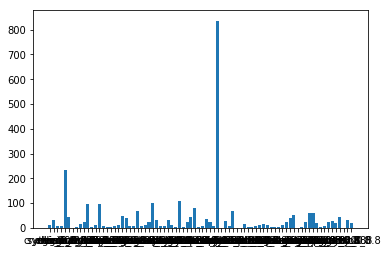

In [13]:
# plot distribution
data = train_fam
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(data)),values,tick_label=names)
plt.savefig('output/train_fam_'+str(tree_min)+'.png')
plt.show()

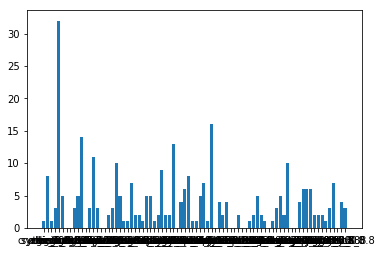

In [14]:
data = valid_fam
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(data)),values,tick_label=names)
plt.savefig('output/valid_fam_'+str(tree_min)+'.png')
plt.show()

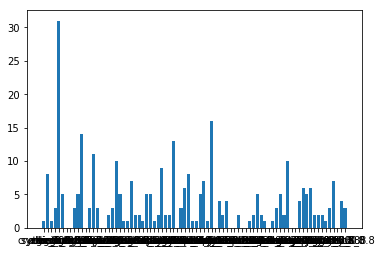

In [15]:
data = test_fam
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(data)),values,tick_label=names)
plt.savefig('output/test_fam_'+str(tree_min)+'.png')
plt.show()

In [39]:
families

['crytex_0.8',
 'symmi_0.8',
 'chir_0.8',
 'elkern_0.8',
 'virut_0.8',
 'graftor_0.8',
 'eggnog_0.8',
 'onlinegames_0.8',
 'strictor_0.8',
 'razy_0.8',
 'zbot_0.8',
 'bundlore_0.8',
 'installrex_0.8',
 'expiro_0.8',
 'killav_0.8',
 'barys_0.8',
 'imali_0.8',
 'ircbot_0.8',
 'firseria_0.8',
 'parite_0.8',
 'somoto_0.8',
 'fesber_0.8',
 'downloadguide_0.8',
 'mira_0.8',
 'downloadadmin_0.8',
 'megasearch_0.8',
 'yantai_0.8',
 'vilsel_0.8',
 'installcore_0.8',
 'valla_0.8',
 'mikey_0.8',
 'mplug_0.8',
 'shiz_0.8',
 'vjadtre_0.8',
 'kazy_0.8',
 'simda_0.8',
 'fakealert_0.8',
 'hotbar_0.8',
 'outbrowse_0.8',
 'kdz_0.8',
 'bettersurf_0.8',
 'browsefox_0.8',
 'upatre_0.8',
 'bdmj_0.8',
 'allaple_0.8',
 'morstar_0.8',
 'ibryte_0.8',
 'domaiq_0.8',
 'mydoom_0.8',
 'hoax_0.8',
 'virlock_0.8',
 'neshta_0.8',
 'delf_0.8',
 'renos_0.8',
 'aira_0.8',
 'vobfus_0.8',
 'msil_0.8',
 'mabezat_0.8',
 'adload_0.8',
 'bifrose_0.8',
 'madangel_0.8',
 'loadmoney_0.8',
 'picsys_0.8',
 'fakeav_0.8',
 'gamevance

In [91]:
fam_list = next(os.walk('./data/tree-rep-logs-profile'))[1]
for fam in fam_list:
    if fam not in families:
        print(fam)

soft_0.8


In [45]:
rep_api[0][:32] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [60]:
fam ,tree

('solimba_0.8', 'G77')

In [73]:
in_directory = root_dir + 'vilsel_0.8' +  '/' + "G244" + '/'
rep_api = pickle.load(open(in_directory+'api_name.pickle','rb')) #(length,32)
rep_param = pickle.load(open(in_directory+'parameter_rep.pickle','rb'))
df_enc = pickle.load(open('output/api_enc2.pkl','rb'))
api_dec = df_enc.idxmax(1)


In [74]:
for api,param in zip(rep_api,rep_param):
    idx_t = np.argmax(api)
    api_name_t = api_dec[idx_t]
    print(api_name_t,param[:5])
#     break
# rep_api
# rep_param[1][:5]

<BOS> <BOS>
RegQueryValue RegQu
RegQueryValue RegQu
<EOS> <EOS>


In [56]:
rep_param

['<BOS>',
 'RegQueryValue#PR@HKLM@sys_setup\\#PR@SUBK@systemsetupinprogress#PR@REG_DWORD#PR@0#Ret#0',
 'LoadLibrary#PR@ARB@windowsshell@MANIFEST#Ret#N',
 'CreateFile#PR@ARB@MANIFEST#PR@GENERIC_READ#PR@OPEN_EXISTING#PR@FILE_SHARE_DELETE;FILE_SHARE_READ#Ret#P',
 'RegQueryValue#PR@HKCU@desktop\\#PR@SUBK@smoothscroll#PR@0#PR@77462a48#Ret#P',
 'RegQueryValue#PR@HKCU@soft_ms_win_explorer\\advanced#PR@SUBK@enableballoontips#PR@0#PR@77462170#Ret#P',
 'RegEnumValue#PR@HKLM@soft_ms_winNT_languagepack\\*#PR@SUBK@surr#PR@REG_DWORD#PR@2#Ret#0',
 '<MOS>',
 'RegQueryValue#PR@HKLM@sys_curCtlSet_ctl_sessionManager\\*#PR@SUBK@criticalsectiontimeout#PR@0#PR@12f9b0#Ret#0',
 'RegQueryValue#PR@HKLM@soft_ms_ole\\*#PR@SUBK@rwlockresourcetimeout#PR@0#PR@12f9b4#Ret#P',
 'LoadLibrary#PR@SYS@uxtheme@DLL#Ret#P',
 'RegQueryValue#PR@HKCU@soft_ms_win_thememanager\\*#PR@SUBK@compositing#PR@12e7f4#PR@12e804#Ret#P',
 'RegQueryValue#PR@HKCU@desktop\\#PR@SUBK@lamebuttontext#PR@12ea00#PR@5ada1620#Ret#P',
 'LoadLibrary#PR@S

In [65]:
#移除錯誤的pickle檔案
fam_dir = next(os.walk(root_dir))[1]
for fam in fam_dir:
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        if not os.path.exists(out_directory):
            os.makedirs(out_directory)
        hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
        hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list
        hl_list = list(filter(lambda f: f.endswith(".pickle"), hl_list)) #remove pickle
        for hkl in hl_list:
#             if len(pickle.load(open(hkl,'rb'))) > 86:
#                 print(hkl , len(pickle.load(open(hkl,'rb'))))
            os.remove(hkl)

In [77]:
# pickle.load(open('./data/tree-rep-logs-profile/strictor_0.8/G125/parameter_rep.pickle','rb'))
# pickle.load(open('./data/tree-rep-logs-profile/delf_0.8/G100/parameter_rep.pickle','rb'))
pickle.load(open('./data/tree-rep-logs-profile/soft_0.8/G33/parameter_rep.pickle','rb'))


['<BOS>',
 'LoadLibrary#PR@SYS@msvcrt@DLL#Ret#P',
 'LoadLibrary#PR@SYS@shlwapi@DLL#Ret#P',
 '<MOS>',
 'CreateFile#PR@ARB@EXE#PR@GENERIC_WRITE#PR@CREATE_ALWAYS#PR@0#Ret#P',
 'CreateProcess#PR@CMD#Ret#P',
 'RegQueryValue#PR@HKCU@soft_ms_win_explorer_shellFolders\\*#PR@SUBK@cache#PR@0#PR@12edbc#Ret#0',
 'LoadLibrary#PR@SYS@advapi32@DLL#Ret#P',
 'ExitProcess#PR@0',
 '<EOS>']

In [70]:
# pickle.load(open('./data/tree-rep-logs-profile/strictor_0.8/G125/parameter_rep.pickle','rb'))
# pickle.load(open('./data/tree-rep-logs/strictor_0.8/G125/rep.pickle','rb'))
# pickle.load(open('./data/tree-rep-logs/delf_0.8/G100/rep.pickle','rb'))
# pickle.load(open('./data/tree-rep-logs/installerex_0.8/G96/rep.pickle','rb'))
# with open('./data/tree-rep-logs-profile/strictor_0.8/G125/5965bd310721735d898b4efeb17628aed22d9fc7dd98bfa6429f579258059228_3212.trace.hooklog','r') as f:
#     lines = f.readlines()
# print(lines)
# len(pickle.load(open('data/tree-rep-logs-profile/soft_0.8/G33/api_name.pickle','rb')))

len(pickle.load(open('data/tree-rep-logs-profile/autoit_0.8/G138/api_name.pickle','rb')))
# len(pickle.load(open('data/tree-rep-logs-profile/autoit_0.8/G138/parameter_rep.pickle','rb')))


118

In [87]:
# len(pickle.load(open('data/tree-rep-logs-profile/yantai_0.8/G46/parameter_rep.pickle','rb')))
# len(pickle.load(open('data/tree-rep-logs-profile/yantai_0.8/G46/api_name.pickle','rb')))

# len(pickle.load(open('data/tree-rep-logs-profile/allaple_0.8/G1286/parameter_rep.pickle','rb')))
# len(pickle.load(open('data/tree-rep-logs-profile/allaple_0.8/G1286/api_name.pickle','rb')))


93

In [13]:
with open('./data/tree-rep-logs-profile/strictor_0.8/G125/5965bd310721735d898b4efeb17628aed22d9fc7dd98bfa6429f579258059228_3260.trace.hooklog','r') as f:
    lines = f.readlines()
print(lines)

['RegQueryValue#PR@HKLM@sys_curCtlSet_ctl_sessionManager\\*#PR@SUBK@criticalsectiontimeout#PR@0#PR@12f9b0#Ret#0\n', 'RegQueryValue#PR@HKLM@soft_ms_ole\\*#PR@SUBK@rwlockresourcetimeout#PR@0#PR@12f9b4#Ret#P\n', 'RegQueryValue#PR@HKLM@sys_setup\\#PR@SUBK@systemsetupinprogress#PR@REG_DWORD#PR@0#Ret#0\n', 'LoadLibrary#PR@ARB@windowsshell@MANIFEST#Ret#N\n', 'CreateFile#PR@ARB@MANIFEST#PR@GENERIC_READ#PR@OPEN_EXISTING#PR@FILE_SHARE_DELETE;FILE_SHARE_READ#Ret#P\n', 'RegQueryValue#PR@HKCU@desktop\\#PR@SUBK@smoothscroll#PR@0#PR@77462a48#Ret#P\n', 'RegQueryValue#PR@HKCU@soft_ms_win_explorer\\advanced#PR@SUBK@enableballoontips#PR@0#PR@77462170#Ret#P\n', 'RegEnumValue#PR@HKLM@soft_ms_winNT_languagepack\\*#PR@SUBK@surr#PR@REG_DWORD#PR@2#Ret#0\n', 'CreateFile#PR@USR@EXE#PR@GENERIC_READ#PR@OPEN_EXISTING#PR@FILE_SHARE_READ#Ret#P\n', 'CreateFile#PR@USR@TMP#PR@GENERIC_READ#PR@CREATE_NEW#PR@0#Ret#P\n', 'DeleteFile#PR@USR@TMP#Ret#P\n', 'CreateFile#PR@USR@EXE#PR@GENERIC_READ#PR@OPEN_EXISTING#PR@FILE_SHARE_R

In [10]:
trainY2.shape

(2838,)

In [16]:
pickle.dump(trainX,open('output/trainX_Param_'+str(trainX.shape[1])+'_'+str(trainX.shape[2])+'.pkl','wb'))
pickle.dump(validX,open('output/validX_Param_'+str(validX.shape[1])+'_'+str(validX.shape[2])+'.pkl','wb'))
pickle.dump(testX,open('output/testX_Param_'+str(testX.shape[1])+'_'+str(testX.shape[2])+'.pkl','wb'))
pickle.dump(trainY2,open('output/trainY2_Param_'+str(trainY2.shape[1])+'_'+str(trainY2.shape[2])+'.pkl','wb'))
pickle.dump(validY2,open('output/validY2_Param_'+str(validY2.shape[1])+'_'+str(validY2.shape[2])+'.pkl','wb'))
pickle.dump(testY2,open('output/testY2_Param_'+str(testY2.shape[1])+'_'+str(testY2.shape[2])+'.pkl','wb'))
trainX.shape  , trainY2.shape

((2838, 116, 300), (2838, 119, 300))

In [ ]:
trainX = pickle.load(open('output/trainX_withParam_128.pkl','rb'))
trainY2 = pickle.load(open('output/trainY2_withParam_128.pkl','rb'))

In [25]:
#feature scaling
max_value = max([np.max(trainX) , np.max(trainY2)])
min_value = min([np.min(trainY),np.min(trainY2)])

# trainX = (trainX - min_value) / (max_value - min_value)
trainY2 = (trainY2 - min_value) / (max_value - min_value )
print(np.max(trainX),np.max(trainY2))

56.984375 1.0


In [26]:
def split_valid_set(X_all, Y_all, percentage):
    all_data_size = len(X_all)
    valid_data_size = int(floor(all_data_size * percentage))

    X_all, Y_all = _shuffle(X_all, Y_all)

    X_train, Y_train = X_all[0:valid_data_size], Y_all[0:valid_data_size]
    X_valid, Y_valid = X_all[valid_data_size:], Y_all[valid_data_size:]

    return X_train, Y_train, X_valid, Y_valid

In [27]:
def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
#     print(X.shape, Y.shape)
    return (X[randomize], Y[randomize])

In [28]:
train_X, train_Y, valid_X, valid_Y = split_valid_set(trainX, trainY2, 0.95)

In [26]:
all_trees_count = []
fam_dir = next(os.walk(root_dir))[1]
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
#     all_trees_count+=len(tree_dir)
    for tree in tree_dir:
        all_trees_count.append(fam+tree)
print(len(all_trees_count))
pickle.dump(file=open('output/tree_name.pkl','wb'),obj=all_trees_count)

100%|██████████| 80/80 [00:00<00:00, 14145.45it/s]

1368


In [24]:
all_trees_count

['crytex_0.8G40',
 'crytex_0.8G47',
 'crytex_0.8G52',
 'crytex_0.8G53',
 'crytex_0.8G42',
 'symmi_0.8G303',
 'symmi_0.8G256',
 'symmi_0.8G278',
 'symmi_0.8G248',
 'symmi_0.8G263',
 'symmi_0.8G317',
 'symmi_0.8G258',
 'symmi_0.8G282',
 'symmi_0.8G311',
 'symmi_0.8G268',
 'symmi_0.8G260',
 'symmi_0.8G290',
 'symmi_0.8G280',
 'symmi_0.8G255',
 'symmi_0.8G312',
 'symmi_0.8G308',
 'symmi_0.8G266',
 'symmi_0.8G274',
 'symmi_0.8G257',
 'symmi_0.8G313',
 'symmi_0.8G250',
 'symmi_0.8G285',
 'symmi_0.8G288',
 'symmi_0.8G306',
 'symmi_0.8G253',
 'symmi_0.8G307',
 'symmi_0.8G295',
 'symmi_0.8G316',
 'symmi_0.8G318',
 'symmi_0.8G289',
 'symmi_0.8G300',
 'symmi_0.8G283',
 'symmi_0.8G301',
 'symmi_0.8G296',
 'symmi_0.8G261',
 'symmi_0.8G304',
 'symmi_0.8G272',
 'chir_0.8G65',
 'chir_0.8G61',
 'chir_0.8G67',
 'chir_0.8G59',
 'chir_0.8G63',
 'elkern_0.8G143',
 'elkern_0.8G203',
 'elkern_0.8G229',
 'elkern_0.8G193',
 'elkern_0.8G188',
 'elkern_0.8G183',
 'elkern_0.8G147',
 'elkern_0.8G220',
 'elkern_0.8

In [258]:
# print(pad_npy.shape)
pad_npy2 = np.expand_dims(pad_npy,axis=0)
print(pad_npy2.shape, train_Y.shape)
C = np.column_stack((train_Y,pad_npy))
C.shape

(1, 1, 37) (3, 260, 37)


ValueError: all the input arrays must have same number of dimensions

In [222]:
#by sample
print(min(all_length_rep), max(all_length_rep), np.mean(all_length_rep), np.std(all_length_rep))
np.percentile(all_length_rep,25) , np.percentile(all_length_rep,50), np.percentile(all_length_rep,75)

1 1964 89.35063689905492 140.23808114819593


(14.0, 56.0, 91.0)

In [220]:
#by tree
print(min(all_length_rep), max(all_length_rep), np.mean(all_length_rep), np.std(all_length_rep))
np.percentile(all_length_rep,25) , np.percentile(all_length_rep,50), np.percentile(all_length_rep,75)

1 1964 104.11208791208792 163.9632940486203


(14.0, 47.0, 107.0)

In [231]:
107+ 1.5*(107-25)

230.0

In [198]:
temp = pickle.load(open(file,'rb'))
print(temp.shape)
if temp.shape[0]<12:
    iter_ = 12-temp.shape[0]
    for i in range(iter_):
        temp = np.append(temp,temp2,axis=0)
temp.shape

(9, 37)


(12, 37)

In [192]:
temp2 = pickle.load(open('output/api_enc.pkl','rb'))
temp2 = temp2['<PAD>'].values
temp2 = np.expand_dims(temp2,axis=0)
temp2.shape

(1, 37)

In [129]:
# Example



hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list

hl_list = list(filter(lambda f: f.endswith(".hooklog"), hl_list)) # in case some non-hooklog file in the folder
exception_count = 0
for file in hl_list:
    try:
        hl3 = Hooklog(file, in_parseFirstPar)
    except UnicodeDecodeError:
        shutil.move(file,'./data/aries_simplified/exception/'+file.split('/')[-1])
        print(file)
        exception_count+=1
print(exception_count)

./data/aries_simplified/01f6bc667f9cae673a84da14b295b7d3dc8d5c04588bc4c958b6a4d7c5a500af_3464.trace.hooklog
./data/aries_simplified/0f6e75fc69c51ba0ef5e5c9d36666b154099668ec9fd9b5f2dda9c059ca101b2_3172.trace.hooklog
./data/aries_simplified/0a010cca5da89ab16e4b5f626268997032c594fa231188ce48b6a546ad6e4f1c_3332.trace.hooklog
./data/aries_simplified/0b1adc128d743eb8d4d03c760fef768dc7b06a8e2c12e6166bccada73ab9913f_3288.trace.hooklog
./data/aries_simplified/0b1f4a70157a48e00d1739128a2dcb8d8e8f46e5c0e9b5ca0678e6bf24cbcce7_3292.trace.hooklog
./data/aries_simplified/887dbf8767d383a93a18ab6f6e42803bbf99c894cde35b64a6534d569e5c81eb_3296.trace.hooklog
./data/aries_simplified/0d0ed35f793afce19ffa101ad6912a441b82f8638571ce8ac96b14f6d8a60b29_3528.trace.hooklog
./data/aries_simplified/0cc68df0aef4db3c10b79aa5b98e0b1f35804b78ee9bcff08afe53d2ec76bf61_3420.trace.hooklog
./data/aries_simplified/0ee346769065d0de1985f0e6d7018f43e0f5fc8f8d578889a72e334e8bed50d6_3344.trace.hooklog
./data/aries_simplified/4abc

(2, 93, 37)

In [50]:
hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list
api_len = []
hl_list = list(filter(lambda f: f.endswith(".hooklog"), hl_list)) # in case some non-hooklog file in the folder
for file in tqdm(hl_list):
    try:
        hl3 = Hooklog(file, in_parseFirstPar)
    except:
        pass
    api_enc = np.empty((0,37))
    for time,api in hl3.li:
#         print(api_enc.shape, df_enc[api].values.shape)
        temp = df_enc[api].values
        temp = np.expand_dims(temp,axis=0)
#         print(api_enc.shape,temp.shape)
        api_enc = np.append(api_enc, temp,axis=0)
#         api_enc = np.stack(api_enc,axis=0)
#         api_enc = df_enc[api].values
    print(api_enc.shape)
    api_len.append(api_enc.shape[0])
    
#     break
        
#         print(v)

(82, 37)
(3360, 37)
(108, 37)
(2114, 37)
(206, 37)
(974, 37)
(198, 37)
(303, 37)
(281, 37)
(1083, 37)
(625, 37)
(1059, 37)
(296, 37)
(351, 37)
(1016, 37)
(144, 37)
(2792, 37)
(894, 37)
(1664, 37)
(102, 37)
(170, 37)
(241, 37)
(306, 37)
(89, 37)
(2295, 37)
(227, 37)
(75, 37)
(43, 37)
(1148, 37)
(1533, 37)
(2116, 37)
(32, 37)
(295, 37)
(32, 37)
(351, 37)
(296, 37)
(67, 37)
(1377, 37)
(50, 37)
(319, 37)
(95, 37)
(1210, 37)
(11, 37)
(81, 37)
(50, 37)
(757, 37)
(267, 37)
(221, 37)
(1375, 37)
(30, 37)
(300, 37)
(148, 37)
(1619, 37)
(125, 37)
(221, 37)
(221, 37)
(920, 37)
(130, 37)
(109, 37)
(19, 37)
(417, 37)
(160, 37)
(53, 37)
(30, 37)
(379, 37)
(153, 37)
(50, 37)
(115, 37)
(218, 37)
(34, 37)
(113, 37)
(453, 37)
(238, 37)
(140, 37)
(521, 37)
(198, 37)
(1425, 37)
(48, 37)
(295, 37)
(1619, 37)
(1305, 37)
(170, 37)
(260, 37)
(1375, 37)
(221, 37)
(50, 37)
(70, 37)
(1208, 37)
(30, 37)
(57, 37)
(136, 37)
(78, 37)
(992, 37)
(2497, 37)
(351, 37)
(529, 37)
(201, 37)
(257, 37)
(70, 37)
(90, 37)
(1662

(268, 37)
(88, 37)
(1619, 37)
(324, 37)
(553, 37)
(152, 37)
(76, 37)
(14, 37)
(896, 37)
(1581, 37)
(1283, 37)
(30, 37)
(48, 37)
(231, 37)
(1543, 37)
(3072, 37)
(319, 37)
(221, 37)
(148, 37)
(221, 37)
(154, 37)
(86, 37)
(974, 37)
(5, 37)
(1619, 37)
(53, 37)
(1913, 37)
(5, 37)
(1377, 37)
(225, 37)
(1619, 37)
(90, 37)
(86, 37)
(32, 37)
(296, 37)
(55, 37)
(35, 37)
(1283, 37)
(171, 37)
(78, 37)
(417, 37)
(174, 37)
(112, 37)
(244, 37)
(43, 37)
(35, 37)
(221, 37)
(198, 37)
(435, 37)
(351, 37)
(32, 37)
(93, 37)
(221, 37)
(351, 37)
(13, 37)
(78, 37)
(532, 37)
(239, 37)
(4799, 37)
(561, 37)
(274, 37)
(320, 37)
(1094, 37)
(476, 37)
(89, 37)
(351, 37)
(179, 37)
(81, 37)
(212, 37)
(119, 37)
(16, 37)
(157, 37)
(28, 37)
(1377, 37)
(1619, 37)
(15, 37)
(1619, 37)
(413, 37)
(25, 37)
(1336, 37)
(80, 37)
(221, 37)
(63, 37)
(323, 37)
(249, 37)
(462, 37)
(250, 37)
(368, 37)
(241, 37)
(161, 37)
(50, 37)
(351, 37)
(25, 37)
(76, 37)
(86, 37)
(267, 37)
(459, 37)
(328, 37)
(103, 37)
(857, 37)
(16, 37)
(1368, 37)

(4529, 37)
(30, 37)
(553, 37)
(918, 37)
(89, 37)
(576, 37)
(51, 37)
(453, 37)
(86, 37)
(303, 37)
(295, 37)
(318, 37)
(194, 37)
(85, 37)
(53, 37)
(303, 37)
(69, 37)
(5, 37)
(1747, 37)
(184, 37)
(198, 37)
(1310, 37)
(221, 37)
(241, 37)
(240, 37)
(1718, 37)
(267, 37)
(284, 37)
(1649, 37)
(259, 37)
(1308, 37)
(15, 37)
(50, 37)
(1383, 37)
(223, 37)
(344, 37)
(417, 37)
(48, 37)
(146, 37)
(688, 37)
(303, 37)
(42, 37)
(42, 37)
(20, 37)
(108, 37)
(91, 37)
(107, 37)
(89, 37)
(300, 37)
(1759, 37)
(161, 37)
(183, 37)
(459, 37)
(94, 37)
(69, 37)
(1057, 37)
(1569, 37)
(221, 37)
(78, 37)
(120, 37)
(1360, 37)
(1619, 37)
(822, 37)
(79, 37)
(758, 37)
(14, 37)
(203, 37)
(175, 37)
(1066, 37)
(155, 37)
(121, 37)
(175, 37)
(917, 37)
(261, 37)
(15240, 37)
(208, 37)
(459, 37)
(183, 37)
(152, 37)
(221, 37)
(8, 37)
(171, 37)
(286, 37)
(89, 37)
(268, 37)
(221, 37)
(212, 37)
(1756, 37)
(11428, 37)
(154, 37)
(1034, 37)
(103, 37)
(403, 37)
(1398, 37)
(193, 37)
(128, 37)
(30, 37)
(237, 37)
(199, 37)
(68, 37)
(247, 3

(2250, 37)
(851, 37)
(303, 37)
(1054, 37)
(214, 37)
(10646, 37)
(147, 37)
(296, 37)
(212, 37)
(268, 37)
(79, 37)
(221, 37)
(57, 37)
(34, 37)
(239, 37)
(241, 37)
(3, 37)
(70, 37)
(167, 37)
(267, 37)
(284, 37)
(139, 37)
(32, 37)
(1559, 37)
(212, 37)
(38, 37)
(295, 37)
(46, 37)
(212, 37)
(1065, 37)
(122, 37)
(240, 37)
(1306, 37)
(161, 37)
(1904, 37)
(295, 37)
(241, 37)
(53, 37)
(1900, 37)
(152, 37)
(32, 37)
(29, 37)
(316, 37)
(1485, 37)
(344, 37)
(1006, 37)
(100, 37)
(198, 37)
(50, 37)
(1200, 37)
(3203, 37)
(50, 37)
(268, 37)
(214, 37)
(14, 37)
(588, 37)
(133, 37)
(267, 37)
(293, 37)
(153, 37)
(263, 37)
(559, 37)
(3361, 37)
(85, 37)
(306, 37)
(198, 37)
(175, 37)
(50, 37)
(1283, 37)
(31, 37)
(30, 37)
(78, 37)
(303, 37)
(221, 37)
(2497, 37)
(135, 37)
(212, 37)
(1383, 37)
(542, 37)
(78, 37)
(959, 37)
(797, 37)
(7, 37)
(133, 37)
(269, 37)
(70, 37)
(110, 37)
(15, 37)
(351, 37)
(221, 37)
(61, 37)
(319, 37)
(206, 37)
(151, 37)
(130, 37)
(308, 37)
(34, 37)
(51, 37)
(1377, 37)
(293, 37)
(28, 37)
(

(1012, 37)
(1748, 37)
(1127, 37)
(1264, 37)
(72, 37)
(13290, 37)
(2253, 37)
(351, 37)
(1147, 37)
(75, 37)
(131, 37)
(221, 37)
(260, 37)
(221, 37)
(303, 37)
(124, 37)
(78, 37)
(6, 37)
(89, 37)
(46, 37)
(5801, 37)
(241, 37)
(101, 37)
(456, 37)
(938, 37)
(206, 37)
(19, 37)
(547, 37)
(152, 37)
(358, 37)
(70, 37)
(255, 37)
(78, 37)
(1288, 37)
(1069, 37)
(351, 37)
(46, 37)
(70, 37)
(813, 37)
(239, 37)
(221, 37)
(476, 37)
(351, 37)
(974, 37)
(57, 37)
(618, 37)
(39, 37)
(13, 37)
(33, 37)
(1364, 37)
(19, 37)
(267, 37)
(932, 37)
(212, 37)
(212, 37)
(9, 37)
(32, 37)
(75, 37)
(221, 37)
(177, 37)
(91, 37)
(653, 37)
(621, 37)
(1619, 37)
(892, 37)
(241, 37)
(22, 37)
(40, 37)
(37, 37)
(3877, 37)
(1385, 37)
(221, 37)
(77, 37)
(42, 37)
(148, 37)
(111, 37)
(221, 37)
(187, 37)
(290, 37)
(241, 37)
(182, 37)
(60, 37)
(351, 37)
(331, 37)
(6, 37)
(2274, 37)
(2123, 37)
(15, 37)
(32, 37)
(417, 37)
(1397, 37)
(351, 37)
(239, 37)
(10, 37)
(295, 37)
(978, 37)
(257, 37)
(125, 37)
(1052, 37)
(1698, 37)
(90, 37)
(345

(1986, 37)
(1976, 37)
(19, 37)
(137, 37)
(153, 37)
(1512, 37)
(89, 37)
(198, 37)
(308, 37)
(1078, 37)
(2791, 37)
(1236, 37)
(580, 37)
(25, 37)
(1, 37)
(50, 37)
(239, 37)
(1542, 37)
(47, 37)
(50, 37)
(295, 37)
(50, 37)
(1014, 37)
(151, 37)
(1377, 37)
(119, 37)
(104, 37)
(44, 37)
(1383, 37)
(1432, 37)
(6, 37)
(901, 37)
(154, 37)
(39, 37)
(295, 37)
(1355, 37)
(1536, 37)
(268, 37)
(221, 37)
(699, 37)
(206, 37)
(12, 37)
(119, 37)
(221, 37)
(256, 37)
(1241, 37)
(148, 37)
(344, 37)
(1210, 37)
(649, 37)
(109, 37)
(324, 37)
(315, 37)
(50, 37)
(1377, 37)
(256, 37)
(712, 37)
(48, 37)
(1065, 37)
(11, 37)
(30, 37)
(1067, 37)
(287, 37)
(901, 37)
(221, 37)
(5, 37)
(199, 37)
(700, 37)
(306, 37)
(21, 37)
(904, 37)
(930, 37)
(241, 37)
(267, 37)
(192, 37)
(1379, 37)
(268, 37)
(138, 37)
(69, 37)
(2640, 37)
(69, 37)
(15, 37)
(221, 37)
(233, 37)
(1620, 37)
(306, 37)
(6065, 37)
(215, 37)
(86, 37)
(25, 37)
(186, 37)
(1302, 37)
(821, 37)
(221, 37)
(364, 37)
(1171, 37)
(267, 37)
(78, 37)
(1249, 37)
(206, 37)
(1

(212, 37)
(896, 37)
(549, 37)
(1315, 37)
(1626, 37)
(1210, 37)
(46, 37)
(260, 37)
(32, 37)
(726, 37)
(241, 37)
(34, 37)
(701, 37)
(852, 37)
(135, 37)
(231, 37)
(38, 37)
(109, 37)
(124, 37)
(212, 37)
(1811, 37)
(9872, 37)
(79, 37)
(50, 37)
(92, 37)
(53, 37)
(601, 37)
(212, 37)
(236, 37)
(159, 37)
(34, 37)
(27, 37)
(1239, 37)
(2, 37)
(9, 37)
(192, 37)
(892, 37)
(295, 37)
(2980, 37)
(141, 37)
(296, 37)
(221, 37)
(29, 37)
(290, 37)
(2454, 37)
(48, 37)
(223, 37)
(1383, 37)
(221, 37)
(34, 37)
(221, 37)
(53, 37)
(536, 37)
(367, 37)
(35, 37)
(292, 37)
(336, 37)
(78, 37)
(122, 37)
(221, 37)
(472, 37)
(123, 37)
(126, 37)
(154, 37)
(2216, 37)
(303, 37)
(547, 37)
(308, 37)
(331, 37)
(303, 37)
(300, 37)
(6, 37)
(267, 37)
(67, 37)
(15, 37)
(1123, 37)
(50, 37)
(1054, 37)
(221, 37)
(91, 37)
(212, 37)
(309, 37)
(167, 37)
(294, 37)
(218, 37)
(250, 37)
(303, 37)
(135, 37)
(66, 37)
(198, 37)
(126, 37)
(351, 37)
(125, 37)
(111, 37)
(245, 37)
(1372, 37)
(221, 37)
(58, 37)
(3113, 37)
(16, 37)
(1228, 37)
(194

(369, 37)
(278, 37)
(834, 37)
(803, 37)
(54, 37)
(21, 37)
(71, 37)
(218, 37)
(1360, 37)
(5, 37)
(206, 37)
(778, 37)
(86, 37)
(295, 37)
(206, 37)
(194, 37)
(1619, 37)
(296, 37)
(294, 37)
(52, 37)
(21, 37)
(296, 37)
(351, 37)
(126, 37)
(40, 37)
(144, 37)
(1532, 37)
(91, 37)
(147, 37)
(267, 37)
(35, 37)
(27, 37)
(126, 37)
(221, 37)
(151, 37)
(145, 37)
(1268, 37)
(67, 37)
(1674, 37)
(918, 37)
(45, 37)
(38, 37)
(1487, 37)
(30, 37)
(17, 37)
(131, 37)
(48, 37)
(151, 37)
(67, 37)
(32, 37)
(206, 37)
(1595, 37)
(290, 37)
(68, 37)
(1, 37)
(306, 37)
(316, 37)
(52, 37)
(15, 37)
(1463, 37)
(23, 37)
(40, 37)
(1847, 37)
(7384, 37)
(239, 37)
(19, 37)
(260, 37)
(50, 37)
(10, 37)
(15, 37)
(521, 37)
(351, 37)
(52, 37)
(17, 37)
(303, 37)
(4561, 37)
(2337, 37)
(35, 37)
(237, 37)
(242, 37)
(33, 37)
(1065, 37)
(1377, 37)
(1205, 37)
(1482, 37)
(1315, 37)
(5, 37)
(303, 37)
(119, 37)
(1025, 37)
(108, 37)
(221, 37)
(206, 37)
(331, 37)
(72, 37)
(23, 37)
(113, 37)
(47, 37)
(126, 37)
(46, 37)
(138, 37)
(119, 37)
(22

(1315, 37)
(199, 37)
(184, 37)
(267, 37)
(20, 37)
(53, 37)
(29, 37)
(1298, 37)
(43, 37)
(86, 37)
(899, 37)
(152, 37)
(285, 37)
(2083, 37)
(93, 37)
(254, 37)
(342, 37)
(8200, 37)
(32, 37)
(45, 37)
(154, 37)
(25, 37)
(1403, 37)
(7, 37)
(351, 37)
(109, 37)
(32, 37)
(1045, 37)
(103, 37)
(189, 37)
(1308, 37)
(805, 37)
(212, 37)
(147, 37)
(303, 37)
(295, 37)
(167, 37)
(171, 37)
(950, 37)
(28, 37)
(295, 37)
(46, 37)
(253, 37)
(221, 37)
(267, 37)
(715, 37)
(50, 37)
(931, 37)
(229, 37)
(242, 37)
(119, 37)
(326, 37)
(63, 37)
(38, 37)
(83, 37)
(518, 37)
(927, 37)
(221, 37)
(122, 37)
(167, 37)
(13, 37)
(300, 37)
(635, 37)
(1431, 37)
(153, 37)
(76, 37)
(267, 37)
(212, 37)
(1192, 37)
(1619, 37)
(209, 37)
(324, 37)
(5, 37)
(1109, 37)
(84, 37)
(1619, 37)
(7, 37)
(920, 37)
(32, 37)
(137, 37)
(19, 37)
(306, 37)
(147, 37)
(228, 37)
(187, 37)
(247, 37)
(295, 37)
(220, 37)
(894, 37)
(32, 37)
(206, 37)
(40, 37)
(221, 37)
(5, 37)
(102, 37)
(207, 37)
(115, 37)
(206, 37)
(190, 37)
(1334, 37)
(126, 37)
(29, 37)

(1038, 37)
(900, 37)
(3899, 37)
(6662, 37)
(185, 37)
(89, 37)
(212, 37)
(32, 37)
(417, 37)
(944, 37)
(154, 37)
(198, 37)
(222, 37)
(81, 37)
(23, 37)
(212, 37)
(303, 37)
(6037, 37)
(332, 37)
(295, 37)
(367, 37)
(3773, 37)
(153, 37)
(5, 37)
(25, 37)
(303, 37)
(48, 37)
(1360, 37)
(302, 37)
(76, 37)
(19, 37)
(1398, 37)
(73, 37)
(303, 37)
(158, 37)
(250, 37)
(50, 37)
(260, 37)
(260, 37)
(303, 37)
(324, 37)
(221, 37)
(39, 37)
(6617, 37)
(50, 37)
(269, 37)
(309, 37)
(557, 37)
(1656, 37)
(341, 37)
(693, 37)
(9131, 37)
(62, 37)
(1265, 37)
(38, 37)
(161, 37)
(80, 37)
(198, 37)
(1619, 37)
(37, 37)
(212, 37)
(1114, 37)
(32, 37)
(64, 37)
(1014, 37)
(336, 37)
(351, 37)
(7, 37)
(27, 37)
(48, 37)
(571, 37)
(1985, 37)
(5, 37)
(268, 37)
(293, 37)
(167, 37)
(409, 37)
(265, 37)
(456, 37)
(2965, 37)
(239, 37)
(268, 37)
(1465, 37)
(221, 37)
(301, 37)
(1377, 37)
(79, 37)
(48, 37)
(296, 37)
(267, 37)
(196, 37)
(70, 37)
(303, 37)
(141, 37)
(35, 37)
(35, 37)
(238, 37)
(239, 37)
(352, 37)
(582, 37)
(336, 37)
(29

(4797, 37)
(295, 37)
(351, 37)
(5, 37)
(293, 37)
(536, 37)
(1202, 37)
(221, 37)
(73, 37)
(198, 37)
(2759, 37)
(48, 37)
(107, 37)
(935, 37)
(32, 37)
(938, 37)
(46, 37)
(989, 37)
(123, 37)
(10881, 37)
(62, 37)
(1279, 37)
(244, 37)
(154, 37)
(148, 37)
(5, 37)
(212, 37)
(5, 37)
(295, 37)
(83, 37)
(18, 37)
(6100, 37)
(7, 37)
(206, 37)
(188, 37)
(303, 37)
(1056, 37)
(29, 37)
(534, 37)
(268, 37)
(89, 37)
(332, 37)
(2, 37)
(331, 37)
(32, 37)
(3687, 37)
(207, 37)
(296, 37)
(268, 37)
(331, 37)
(122, 37)
(1006, 37)
(917, 37)
(144, 37)
(308, 37)
(221, 37)
(1320, 37)
(303, 37)
(316, 37)
(221, 37)
(341, 37)
(548, 37)
(539, 37)
(16, 37)
(351, 37)
(18, 37)
(293, 37)
(239, 37)
(50, 37)
(164, 37)
(70, 37)
(1883, 37)
(43, 37)
(7, 37)
(303, 37)
(155, 37)
(25, 37)
(1483, 37)
(351, 37)
(765, 37)
(462, 37)
(432, 37)
(63, 37)
(35, 37)
(79, 37)
(221, 37)
(195, 37)
(206, 37)
(211, 37)
(425, 37)
(1016, 37)
(2111, 37)
(1382, 37)
(20, 37)
(69, 37)
(853, 37)
(32, 37)
(432, 37)
(221, 37)
(92, 37)
(308, 37)
(161, 37)

(192, 37)
(188, 37)
(45, 37)
(227, 37)
(50, 37)
(231, 37)
(2, 37)
(295, 37)
(198, 37)
(32, 37)
(32, 37)
(15, 37)
(142, 37)
(1375, 37)
(1472, 37)
(45, 37)
(875, 37)
(92, 37)
(139, 37)
(183, 37)
(53, 37)
(66, 37)
(228, 37)
(127, 37)
(1065, 37)
(360, 37)
(100, 37)
(324, 37)
(3191, 37)
(1619, 37)
(1377, 37)
(528, 37)
(274, 37)
(362, 37)
(212, 37)
(736, 37)
(503, 37)
(11, 37)
(206, 37)
(268, 37)
(241, 37)
(119, 37)
(5415, 37)
(15, 37)
(539, 37)
(268, 37)
(57, 37)
(154, 37)
(245, 37)
(221, 37)
(165, 37)
(238, 37)
(456, 37)
(534, 37)
(296, 37)
(87, 37)
(115, 37)
(1619, 37)
(119, 37)
(154, 37)
(75, 37)
(5, 37)
(303, 37)
(938, 37)
(103, 37)
(512, 37)
(306, 37)
(1023, 37)
(1376, 37)
(9, 37)
(221, 37)
(1401, 37)
(250, 37)
(295, 37)
(647, 37)
(16, 37)
(48, 37)
(31, 37)
(206, 37)
(295, 37)
(2, 37)
(464, 37)
(1377, 37)
(95, 37)
(190, 37)
(255, 37)
(461, 37)
(160, 37)
(785, 37)
(221, 37)
(109, 37)
(93, 37)
(212, 37)
(1619, 37)
(1284, 37)
(456, 37)
(973, 37)
(89, 37)
(1619, 37)
(17, 37)
(554, 37)
(212

(1020, 37)
(1379, 37)
(165, 37)
(296, 37)
(430, 37)
(221, 37)
(42, 37)
(13, 37)
(126, 37)
(199, 37)
(212, 37)
(206, 37)
(1898, 37)
(221, 37)
(6, 37)
(221, 37)
(726, 37)
(32, 37)
(159, 37)
(215, 37)
(295, 37)
(559, 37)
(277, 37)
(616, 37)
(2083, 37)
(207, 37)
(303, 37)
(336, 37)
(314, 37)
(542, 37)
(48, 37)
(50, 37)
(278, 37)
(295, 37)
(242, 37)
(351, 37)
(83, 37)
(351, 37)
(96, 37)
(303, 37)
(32, 37)
(130, 37)
(6, 37)
(5, 37)
(196, 37)
(1381, 37)
(109, 37)
(91, 37)
(221, 37)
(40, 37)
(1619, 37)
(221, 37)
(1328, 37)
(144, 37)
(1235, 37)
(221, 37)
(167, 37)
(1147, 37)
(6784, 37)
(1833, 37)
(552, 37)
(206, 37)
(206, 37)
(212, 37)
(1449, 37)
(148, 37)
(268, 37)
(238, 37)
(83, 37)
(303, 37)
(221, 37)
(717, 37)
(1619, 37)
(6236, 37)
(1878, 37)
(333, 37)
(258, 37)
(303, 37)
(272, 37)
(555, 37)
(916, 37)
(243, 37)
(32, 37)
(1299, 37)
(37, 37)
(1706, 37)
(1377, 37)
(559, 37)
(206, 37)
(298, 37)
(303, 37)
(15, 37)
(48, 37)
(86, 37)
(1152, 37)
(241, 37)
(161, 37)
(1308, 37)
(40, 37)
(50, 37)
(5, 

(221, 37)
(1488, 37)
(247, 37)
(221, 37)
(46, 37)
(1847, 37)
(909, 37)
(1320, 37)
(126, 37)
(254, 37)
(57, 37)
(9590, 37)
(435, 37)
(119, 37)
(29086, 37)
(83, 37)
(1922, 37)
(1369, 37)
(181, 37)
(303, 37)
(1953, 37)
(1928, 37)
(198, 37)
(287, 37)
(986, 37)
(290, 37)
(272, 37)
(1315, 37)
(176, 37)
(70, 37)
(45, 37)
(303, 37)
(71, 37)
(238, 37)
(274, 37)
(63, 37)
(353, 37)
(221, 37)
(3294, 37)
(52, 37)
(847, 37)
(29, 37)
(1149, 37)
(118, 37)
(50, 37)
(727, 37)
(56167, 37)
(171, 37)
(198, 37)
(2, 37)
(365, 37)
(14, 37)
(50, 37)
(351, 37)
(243, 37)
(221, 37)
(303, 37)
(74, 37)
(310, 37)
(300, 37)
(198, 37)
(260, 37)
(91, 37)
(895, 37)
(1135, 37)
(89, 37)
(133, 37)
(1065, 37)
(260, 37)
(538, 37)
(575, 37)
(11, 37)
(170, 37)
(1377, 37)
(67, 37)
(221, 37)
(170, 37)
(1069, 37)
(42, 37)
(303, 37)
(188, 37)
(5, 37)
(43, 37)
(198, 37)
(247, 37)
(221, 37)
(708, 37)
(1865, 37)
(260, 37)
(198, 37)
(1016, 37)
(1324, 37)
(303, 37)
(279, 37)
(240, 37)
(206, 37)
(28, 37)
(11, 37)
(1357, 37)
(2497, 37)
(

(7097, 37)
(544, 37)
(2, 37)
(89, 37)
(8, 37)
(551, 37)
(251, 37)
(320, 37)
(184, 37)
(894, 37)
(191, 37)
(206, 37)
(207, 37)
(154, 37)
(69, 37)
(6, 37)
(1320, 37)
(160, 37)
(1315, 37)
(75, 37)
(103, 37)
(48, 37)
(295, 37)
(1210, 37)
(1325, 37)
(1752, 37)
(114, 37)
(154, 37)
(221, 37)
(1002, 37)
(34, 37)
(11, 37)
(919, 37)
(151, 37)
(238, 37)
(181, 37)
(32, 37)
(1377, 37)
(133, 37)
(290, 37)
(543, 37)
(12, 37)
(32, 37)
(91, 37)
(2, 37)
(251, 37)
(238, 37)
(2036, 37)
(84, 37)
(714, 37)
(19, 37)
(91, 37)
(63, 37)
(284, 37)
(12, 37)
(178, 37)
(315, 37)
(117, 37)
(632, 37)
(89, 37)
(560, 37)
(65, 37)
(235, 37)
(235, 37)
(65, 37)
(984, 37)
(49, 37)
(206, 37)
(7, 37)
(184, 37)
(171, 37)
(1085, 37)
(185, 37)
(97, 37)
(115, 37)
(152, 37)
(206, 37)
(5, 37)
(300, 37)
(19, 37)
(53, 37)
(269, 37)
(46, 37)
(351, 37)
(44, 37)
(2675, 37)
(131, 37)
(1334, 37)
(241, 37)
(1, 37)
(1065, 37)
(221, 37)
(351, 37)
(367, 37)
(89, 37)
(83, 37)
(221, 37)
(32, 37)
(1066, 37)
(306, 37)
(151, 37)
(207, 37)
(69, 37

(6544, 37)
(885, 37)
(1315, 37)
(295, 37)
(1312, 37)
(227, 37)
(1406, 37)
(168, 37)
(123, 37)
(1741, 37)
(551, 37)
(1294, 37)
(1354, 37)
(184, 37)
(345, 37)
(71, 37)
(618, 37)
(89, 37)
(524, 37)
(1967, 37)
(332, 37)
(5, 37)
(295, 37)
(221, 37)
(417, 37)
(1882, 37)
(28, 37)
(417, 37)
(85, 37)
(62, 37)
(1011, 37)
(221, 37)
(196, 37)
(106, 37)
(1377, 37)
(50, 37)
(92, 37)
(81, 37)
(187, 37)
(190, 37)
(1283, 37)
(206, 37)
(295, 37)
(279, 37)
(53, 37)
(1305, 37)
(847, 37)
(78, 37)
(895, 37)
(83, 37)
(154, 37)
(21, 37)
(453, 37)
(1734, 37)
(228, 37)
(140, 37)
(142, 37)
(198, 37)
(1377, 37)
(129, 37)
(456, 37)
(177, 37)
(206, 37)
(153, 37)
(303, 37)
(618, 37)
(193, 37)
(89, 37)
(128, 37)
(240, 37)
(5, 37)
(221, 37)
(114, 37)
(38, 37)
(160, 37)
(37, 37)
(30, 37)
(118, 37)
(7, 37)
(706, 37)
(1184, 37)
(239, 37)
(89, 37)
(184, 37)
(206, 37)
(1276, 37)
(52, 37)
(1236, 37)
(413, 37)
(1152, 37)
(180, 37)
(171, 37)
(877, 37)
(206, 37)
(1139, 37)
(1015, 37)
(221, 37)
(1051, 37)
(241, 37)
(2349, 37)
(

(5780, 37)
(351, 37)
(81, 37)
(241, 37)
(2, 37)
(295, 37)
(1320, 37)
(453, 37)
(46, 37)
(86, 37)
(1839, 37)
(14, 37)
(221, 37)
(198, 37)
(231, 37)
(63, 37)
(62, 37)
(115, 37)
(32, 37)
(86, 37)
(351, 37)
(257, 37)
(9827, 37)
(351, 37)
(577, 37)
(2317, 37)
(79, 37)
(306, 37)
(52, 37)
(54, 37)
(1377, 37)
(916, 37)
(16, 37)
(99, 37)
(354, 37)
(239, 37)
(126, 37)
(171, 37)
(46, 37)
(370, 37)
(916, 37)
(191, 37)
(68, 37)
(198, 37)
(63, 37)
(312, 37)
(50, 37)
(215, 37)
(1147, 37)
(11, 37)
(294, 37)
(1147, 37)
(6014, 37)
(1210, 37)
(812, 37)
(185, 37)
(89, 37)
(71, 37)
(944, 37)
(25, 37)
(221, 37)
(306, 37)
(2083, 37)
(198, 37)
(46, 37)
(1148, 37)
(53, 37)
(243, 37)
(37, 37)
(5, 37)
(6, 37)
(690, 37)
(221, 37)
(1144, 37)
(243, 37)
(32, 37)
(33, 37)
(214, 37)
(295, 37)
(91, 37)
(306, 37)
(221, 37)
(198, 37)
(698, 37)
(16, 37)
(228, 37)
(271, 37)
(206, 37)
(231, 37)
(67, 37)
(206, 37)
(221, 37)
(271, 37)
(1648, 37)
(18, 37)
(315, 37)
(1962, 37)
(289, 37)
(1020, 37)
(459, 37)
(154, 37)
(207, 37)


(6482, 37)
(7, 37)
(188, 37)
(167, 37)
(1052, 37)
(276, 37)
(57, 37)
(267, 37)
(559, 37)
(5990, 37)
(1, 37)
(145, 37)
(234, 37)
(21, 37)
(571, 37)
(229, 37)
(303, 37)
(206, 37)
(43, 37)
(28, 37)
(228, 37)
(116, 37)
(88, 37)
(159, 37)
(547, 37)
(221, 37)
(614, 37)
(77, 37)
(295, 37)
(96, 37)
(221, 37)
(351, 37)
(7, 37)
(541, 37)
(68, 37)
(1449, 37)
(213, 37)
(274, 37)
(192, 37)
(1439, 37)
(170, 37)
(168, 37)
(917, 37)
(552, 37)
(351, 37)
(221, 37)
(454, 37)
(206, 37)
(142, 37)
(893, 37)
(1404, 37)
(188, 37)
(344, 37)
(295, 37)
(241, 37)
(1380, 37)
(899, 37)
(268, 37)
(202, 37)
(260, 37)
(235, 37)
(120, 37)
(343, 37)
(1047, 37)
(265, 37)
(140, 37)
(42, 37)
(208, 37)
(192, 37)
(303, 37)
(887, 37)
(154, 37)
(239, 37)
(916, 37)
(32, 37)
(46, 37)
(91, 37)
(295, 37)
(294, 37)
(122, 37)
(203, 37)
(5986, 37)
(148, 37)
(157, 37)
(154, 37)
(12, 37)
(1377, 37)
(176, 37)
(1022, 37)
(1410, 37)
(28, 37)
(198, 37)
(157, 37)
(351, 37)
(1619, 37)
(1357, 37)
(105, 37)
(549, 37)
(6545, 37)
(24, 37)
(1139,

(370, 37)
(294, 37)
(76, 37)
(539, 37)
(303, 37)
(7873, 37)
(5, 37)
(109, 37)
(541, 37)
(136, 37)
(105, 37)
(476, 37)
(221, 37)
(49, 37)
(296, 37)
(198, 37)
(187, 37)
(208, 37)
(70, 37)
(27, 37)
(300, 37)
(108, 37)
(221, 37)
(417, 37)
(31, 37)
(1359, 37)
(709, 37)
(6, 37)
(50, 37)
(241, 37)
(32, 37)
(32, 37)
(294, 37)
(46, 37)
(576, 37)
(212, 37)
(32, 37)
(198, 37)
(233, 37)
(5656, 37)
(903, 37)
(221, 37)
(375, 37)
(1135, 37)
(2305, 37)
(152, 37)
(221, 37)
(57, 37)
(50, 37)
(45, 37)
(5490, 37)
(212, 37)
(32, 37)
(177, 37)
(344, 37)
(15, 37)
(149, 37)
(72, 37)
(206, 37)
(40, 37)
(331, 37)
(221, 37)
(198, 37)
(89, 37)
(207, 37)
(71, 37)
(89, 37)
(336, 37)
(50, 37)
(241, 37)
(1358, 37)
(14, 37)
(295, 37)
(222, 37)
(1006, 37)
(300, 37)
(81, 37)
(154, 37)
(1368, 37)
(2083, 37)
(1315, 37)
(153, 37)
(206, 37)
(1358, 37)
(152, 37)
(280, 37)
(1291, 37)
(88, 37)
(35, 37)
(294, 37)
(1619, 37)
(539, 37)
(142, 37)
(86, 37)
(639, 37)
(894, 37)
(233, 37)
(2086, 37)
(195, 37)
(92, 37)
(538, 37)
(119, 

(1619, 37)
(189, 37)
(38, 37)
(263, 37)
(84, 37)
(294, 37)
(239, 37)
(35, 37)
(38, 37)
(295, 37)
(590, 37)
(214, 37)
(918, 37)
(207, 37)
(168, 37)
(6, 37)
(29, 37)
(5, 37)
(247, 37)
(1426, 37)
(459, 37)
(1619, 37)
(237, 37)
(48, 37)
(957, 37)
(1, 37)
(303, 37)
(303, 37)
(221, 37)
(1377, 37)
(417, 37)
(218, 37)
(5, 37)
(43, 37)
(76, 37)
(167, 37)
(120, 37)
(1619, 37)
(63, 37)
(97, 37)
(87, 37)
(72, 37)
(295, 37)
(89, 37)
(31, 37)
(91, 37)
(503, 37)
(1014, 37)
(444, 37)
(21, 37)
(48, 37)
(367, 37)
(303, 37)
(351, 37)
(91, 37)
(28, 37)
(1298, 37)
(267, 37)
(89, 37)
(11, 37)
(221, 37)
(303, 37)
(99, 37)
(213, 37)
(136, 37)
(153, 37)
(5, 37)
(553, 37)
(32, 37)
(206, 37)
(1305, 37)
(159, 37)
(35, 37)
(257, 37)
(1200, 37)
(163, 37)
(198, 37)
(1377, 37)
(116, 37)
(185, 37)
(1056, 37)
(16, 37)
(56, 37)
(260, 37)
(113, 37)
(918, 37)
(18, 37)
(71, 37)
(1488, 37)
(117, 37)
(158, 37)
(183, 37)
(858, 37)
(85, 37)
(2520, 37)
(178, 37)
(32, 37)
(267, 37)
(1585, 37)
(241, 37)
(206, 37)
(146, 37)
(37, 3

(206, 37)
(123, 37)
(14, 37)
(1045, 37)
(271, 37)
(2730, 37)
(33, 37)
(206, 37)
(48, 37)
(221, 37)
(239, 37)
(406, 37)
(167, 37)
(143, 37)
(221, 37)
(191, 37)
(241, 37)
(991, 37)
(555, 37)
(35, 37)
(462, 37)
(352, 37)
(1147, 37)
(516, 37)
(306, 37)
(481, 37)
(42, 37)
(1901, 37)
(60, 37)
(303, 37)
(155, 37)
(154, 37)
(18, 37)
(216, 37)
(212, 37)
(54, 37)
(36, 37)
(32, 37)
(6, 37)
(221, 37)
(417, 37)
(1315, 37)
(296, 37)
(72, 37)
(188, 37)
(113, 37)
(109, 37)
(221, 37)
(1, 37)
(1759, 37)
(99, 37)
(197, 37)
(553, 37)
(376, 37)
(151, 37)
(239, 37)
(1375, 37)
(376, 37)
(1415, 37)
(156, 37)
(2356, 37)
(1377, 37)
(114, 37)
(153, 37)
(376, 37)
(617, 37)
(545, 37)
(125, 37)
(75, 37)
(21, 37)
(2083, 37)
(63, 37)
(221, 37)
(46, 37)
(2135, 37)
(1573, 37)
(1377, 37)
(333, 37)
(241, 37)
(267, 37)
(539, 37)
(96, 37)
(4883, 37)
(221, 37)
(89, 37)
(6, 37)
(417, 37)
(93, 37)
(155, 37)
(303, 37)
(226, 37)
(75, 37)
(301, 37)
(212, 37)
(221, 37)
(945, 37)
(336, 37)
(267, 37)
(300, 37)
(417, 37)
(221, 37)
(

(6969, 37)
(6, 37)
(35, 37)
(198, 37)
(267, 37)
(504, 37)
(221, 37)
(34, 37)
(28, 37)
(486, 37)
(24, 37)
(3746, 37)
(21, 37)
(221, 37)
(1496, 37)
(544, 37)
(290, 37)
(169, 37)
(1471, 37)
(902, 37)
(62, 37)
(1619, 37)
(221, 37)
(198, 37)
(295, 37)
(690, 37)
(167, 37)
(12, 37)
(303, 37)
(1320, 37)
(303, 37)
(319, 37)
(241, 37)
(1020, 37)
(1489, 37)
(691, 37)
(1354, 37)
(68, 37)
(15, 37)
(1975, 37)
(295, 37)
(140, 37)
(125, 37)
(273, 37)
(151, 37)
(357, 37)
(279, 37)
(1653, 37)
(37, 37)
(129, 37)
(414, 37)
(294, 37)
(1413, 37)
(311, 37)
(895, 37)
(149, 37)
(90, 37)
(552, 37)
(145, 37)
(107, 37)
(83, 37)
(1316, 37)
(1100, 37)
(234, 37)
(532, 37)
(1310, 37)
(1298, 37)
(108, 37)
(351, 37)
(151, 37)
(38, 37)
(205, 37)
(918, 37)
(78, 37)
(67, 37)
(888, 37)
(153, 37)
(48, 37)
(122, 37)
(7, 37)
(397, 37)
(245, 37)
(237, 37)
(138, 37)
(95, 37)
(331, 37)
(895, 37)
(331, 37)
(234, 37)
(19, 37)
(945, 37)
(221, 37)
(32, 37)
(235, 37)
(1290, 37)
(931, 37)
(37, 37)
(198, 37)
(549, 37)
(90, 37)
(887, 37

(3380, 37)
(214, 37)
(267, 37)
(218, 37)
(206, 37)
(1950, 37)
(1349, 37)
(241, 37)
(105, 37)
(22, 37)
(38, 37)
(917, 37)
(551, 37)
(32, 37)
(1377, 37)
(257, 37)
(157, 37)
(303, 37)
(133, 37)
(295, 37)
(1, 37)
(260, 37)
(237, 37)
(206, 37)
(133, 37)
(221, 37)
(29, 37)
(53, 37)
(84, 37)
(154, 37)
(154, 37)
(295, 37)
(417, 37)
(91, 37)
(32, 37)
(62, 37)
(647, 37)
(835, 37)
(34, 37)
(29, 37)
(41, 37)
(921, 37)
(303, 37)
(188, 37)
(166, 37)
(3303, 37)
(231, 37)
(46, 37)
(852, 37)
(71, 37)
(701, 37)
(351, 37)
(10078, 37)
(3471, 37)
(43, 37)
(1403, 37)
(133, 37)
(1331, 37)
(918, 37)
(504, 37)
(128, 37)
(3152, 37)
(2, 37)
(336, 37)
(32, 37)
(65, 37)
(167, 37)
(42, 37)
(45, 37)
(221, 37)
(16, 37)
(202, 37)
(295, 37)
(411, 37)
(920, 37)
(846, 37)
(736, 37)
(1524, 37)
(266, 37)
(1485, 37)
(555, 37)
(254, 37)
(153, 37)
(50, 37)
(264, 37)
(268, 37)
(230, 37)
(56, 37)
(453, 37)
(19, 37)
(1377, 37)
(130, 37)
(78, 37)
(295, 37)
(154, 37)
(121, 37)
(435, 37)
(303, 37)
(1117, 37)
(69, 37)
(198, 37)
(36,

(5709, 37)
(295, 37)
(320, 37)
(221, 37)
(295, 37)
(1571, 37)
(207, 37)
(40, 37)
(1393, 37)
(410, 37)
(1088, 37)
(1837, 37)
(221, 37)
(351, 37)
(30, 37)
(116, 37)
(221, 37)
(70, 37)
(52, 37)
(241, 37)
(72, 37)
(42, 37)
(112, 37)
(327, 37)
(5, 37)
(28, 37)
(296, 37)
(1199, 37)
(303, 37)
(267, 37)
(5636, 37)
(120, 37)
(7, 37)
(147, 37)
(1226, 37)
(221, 37)
(530, 37)
(178, 37)
(167, 37)
(1199, 37)
(125, 37)
(212, 37)
(242, 37)
(50, 37)
(303, 37)
(43, 37)
(1492, 37)
(11, 37)
(455, 37)
(6007, 37)
(12, 37)
(388, 37)
(3088, 37)
(98, 37)
(2147, 37)
(300, 37)
(25, 37)
(543, 37)
(170, 37)
(109, 37)
(262, 37)
(311, 37)
(206, 37)
(32, 37)
(257, 37)
(462, 37)
(149, 37)
(184, 37)
(24, 37)
(5117, 37)
(281, 37)
(78, 37)
(370, 37)
(228, 37)
(75, 37)
(260, 37)
(714, 37)
(69, 37)
(274, 37)
(892, 37)
(361, 37)
(6, 37)
(117, 37)
(170, 37)
(934, 37)
(156, 37)
(221, 37)
(351, 37)
(83, 37)
(176, 37)
(67, 37)
(32, 37)
(154, 37)
(417, 37)
(295, 37)
(32, 37)
(351, 37)
(12, 37)
(565, 37)
(331, 37)
(94, 37)
(806, 

In [54]:
api_len_ind = [i for i in range(len(api_len))]
api_len_ind

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [108]:
df = pd.DataFrame(pd.Series(api_len))
df.to_excel('output/stat.xlsx')

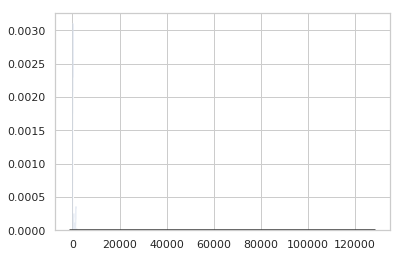

In [96]:
# api_len.sort()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats, integrate
# sns.set(style="whitegrid")
ax = sns.distplot(api_len,bins=2000,kde=False,fit=stats.gamma)
plt.show()

In [70]:
np.mean(api_len) , np.std(api_len) , np.percentile(api_len,50) , np.percentile(api_len,25) , np.percentile(api_len,75)

(564.9238405615442, 2239.6467360046886, 221.0, 83.0, 453.0)

In [105]:
np.max(api_len) , np.min(api_len) , np.percentile(api_len,84.6)

(127365, 1, 1010.0)

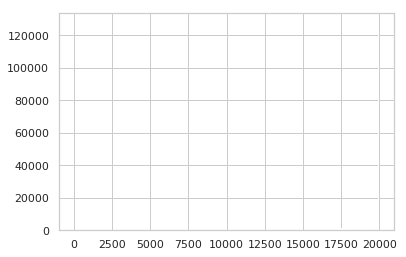

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
ys = api_len
xs = api_len_ind
width=0.1

fig = plt.figure()                                                               
ax = fig.gca()  #get current axes
ax.bar(xs, ys, width,color='b', align='edge')
plt.savefig('output/netscore.png')

In [130]:
# Test

# print last hl3
print("=====")
print(hl3)

# get the api call sequence of last hk3
#print("=====")
#for time, api in hl3.li:
#    print(time, api)

# print each item

for i in hl3.li:
    print(i)

=====
class Hooklog3, ./data/aries_simplified/da974f5000a0af1023c5a0b4110dacf0f8d60ca60360cc0e93eb1d861b1fe8b1_3404.trace.hooklog, par = 0, len = 6, digit name = da974f-3404
('558550000', 'RegOpenKey')
('558750000', 'LoadLibrary')
('559730000', 'LoadLibrary')
('560390000', 'LoadLibrary')
('560390000', 'LoadLibrary')
('560620000', 'RegOpenKey')


In [19]:
# output
import pickle

out_hl_list = hl_list
out_tag = in_tag
with open(out_picklefile, 'wb') as o:
    pickle.dump(out_hl_list, o)

In [13]:
hl3

In [20]:
# output 2
with open(out_csvfile, 'wb') as o:
    o.write(b"hooklog\n")
    for h in hl_list:
        o.write(h.encode("ascii") + b"\n")

In [23]:
# output 3
total_api_set = set()
for file in hl_list:
    try:
        hl3 = Hooklog(file, in_parseFirstPar)
    except UnicodeDecodeError:
        print(file)
    total_api_set.update(hl3.getWinSet(in_window))

with open(out_featuretabfile, 'wb') as o:
    o.write(b"hooklog")
    for api in total_api_set:
        o.write(b"\t" + api.encode("ascii"))
    o.write(b"\n")
    
    for h in hl_list:
        try:
            hl3 = Hooklog(h, in_parseFirstPar)
        except UnicodeDecodeError:
            print(h)
        hl3_set = hl3.getWinSet(in_window)
        o.write(hl3.digitname.encode("ascii"))
        for api in total_api_set:
            if api in hl3_set:
                o.write(b"\tTrue")
            else:
                o.write(b"\tFalse")
        o.write(b"\n")

./data/aries_simplified/01f6bc667f9cae673a84da14b295b7d3dc8d5c04588bc4c958b6a4d7c5a500af_3464.trace.hooklog
./data/aries_simplified/0f6e75fc69c51ba0ef5e5c9d36666b154099668ec9fd9b5f2dda9c059ca101b2_3172.trace.hooklog
./data/aries_simplified/0a010cca5da89ab16e4b5f626268997032c594fa231188ce48b6a546ad6e4f1c_3332.trace.hooklog
./data/aries_simplified/0b1adc128d743eb8d4d03c760fef768dc7b06a8e2c12e6166bccada73ab9913f_3288.trace.hooklog
./data/aries_simplified/0b1f4a70157a48e00d1739128a2dcb8d8e8f46e5c0e9b5ca0678e6bf24cbcce7_3292.trace.hooklog
./data/aries_simplified/887dbf8767d383a93a18ab6f6e42803bbf99c894cde35b64a6534d569e5c81eb_3296.trace.hooklog
./data/aries_simplified/0d0ed35f793afce19ffa101ad6912a441b82f8638571ce8ac96b14f6d8a60b29_3528.trace.hooklog
./data/aries_simplified/0cc68df0aef4db3c10b79aa5b98e0b1f35804b78ee9bcff08afe53d2ec76bf61_3420.trace.hooklog
./data/aries_simplified/0ee346769065d0de1985f0e6d7018f43e0f5fc8f8d578889a72e334e8bed50d6_3344.trace.hooklog
./data/aries_simplified/4abc

./data/aries_simplified/c6d288841b9719a01bd340da55538ce43aaa74265791a41ee493cabde9d2402e_2960.trace.hooklog
./data/aries_simplified/0d8c14c0986342b567a68bab41c93a27baa03d4a9baac9ef17264ffc947a6732_2960.trace.hooklog
./data/aries_simplified/0bb2f126798346d8661e5b8e1e452900947c17e7dede8dc410a37f8663898863_2940.trace.hooklog
./data/aries_simplified/0e7727730e917c9d4f691b12be62cef32613b5b727732d54a7747247d62f7803_3340.trace.hooklog
./data/aries_simplified/0eb635b092f2f29eed29508efdea15e937a711801504552101c61c5b9ea9918e_2824.trace.hooklog
./data/aries_simplified/0e9722c8c1c20179f1114e267c2ebb5ff80ab451a49603978d9a89f8db05708c_2904.trace.hooklog
./data/aries_simplified/0d6c63276b7a6d1929f9faa1ed35e9327b0f3957cd66d71111f9540186ee49c9_3200.trace.hooklog
./data/aries_simplified/0a878b44297513f8b5ae1f46e5d4da96ec24d8eddd5afff1cd8ccf2a232cbe97_3264.trace.hooklog


In [25]:
# output 4
# count api freq
freq_dict = dict()
exception_count = 0
for file in hl_list:
    try:
        hl3 = Hooklog(file, in_parseFirstPar)
    except UnicodeDecodeError:
        print(file)
        exception_count+=1
    for i in hl3.li:
        if i[1] not in freq_dict:
            freq_dict[i[1]] = 1
        else:
            freq_dict[i[1]] += 1

print(freq_dict)
print(exception_count)
import pickle
with open(out_apifreq_pk, 'wb') as o:
    pickle.dump(freq_dict, o)

./data/aries_simplified/01f6bc667f9cae673a84da14b295b7d3dc8d5c04588bc4c958b6a4d7c5a500af_3464.trace.hooklog
./data/aries_simplified/0f6e75fc69c51ba0ef5e5c9d36666b154099668ec9fd9b5f2dda9c059ca101b2_3172.trace.hooklog
./data/aries_simplified/0a010cca5da89ab16e4b5f626268997032c594fa231188ce48b6a546ad6e4f1c_3332.trace.hooklog
./data/aries_simplified/0b1adc128d743eb8d4d03c760fef768dc7b06a8e2c12e6166bccada73ab9913f_3288.trace.hooklog
./data/aries_simplified/0b1f4a70157a48e00d1739128a2dcb8d8e8f46e5c0e9b5ca0678e6bf24cbcce7_3292.trace.hooklog
./data/aries_simplified/887dbf8767d383a93a18ab6f6e42803bbf99c894cde35b64a6534d569e5c81eb_3296.trace.hooklog
./data/aries_simplified/0d0ed35f793afce19ffa101ad6912a441b82f8638571ce8ac96b14f6d8a60b29_3528.trace.hooklog
./data/aries_simplified/0cc68df0aef4db3c10b79aa5b98e0b1f35804b78ee9bcff08afe53d2ec76bf61_3420.trace.hooklog
./data/aries_simplified/0ee346769065d0de1985f0e6d7018f43e0f5fc8f8d578889a72e334e8bed50d6_3344.trace.hooklog
./data/aries_simplified/4abc

In [43]:
import sklearn
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [118]:
api_list = list(freq_dict.keys())
api_list.extend(['<BOS>','<EOS>','<MOS>','<PAD>','<UNK>'])
api_list

['LoadLibrary',
 'RegOpenKey',
 'RegQueryValue',
 'RegCloseKey',
 'CreateFile',
 'CloseHandle',
 'RegOpenCurrentUser',
 'RegEnumValue',
 'RegCreateKey',
 'OpenProcess',
 'CreateRemoteThread',
 'CreateThread',
 'RegSetValue',
 'RegDeleteValue',
 'InternetOpen',
 'InternetConnect',
 'HttpSendRequest',
 'ExitProcess',
 'CreateProcess',
 'DeleteFile',
 'WinHttpOpen',
 'WinHttpConnect',
 'WinHttpOpenRequest',
 'WinHttpSendRequest',
 'WinHttpReadData',
 'CopyFile',
 'OpenThread',
 'RegDeleteKey',
 'TerminateProcess',
 'WinExec',
 'GetUrlCacheEntryInfo',
 'WinHttpWriteData',
 '<BOS>',
 '<EOS>',
 '<MOS>',
 '<PAD>',
 '<UNK>']

In [119]:
# len(freq_dict)

ser = pd.Series(api_list)
df = pd.DataFrame(ser)
df.columns = ['api']
df2 = pd.get_dummies(df['api'])
df2
# enc = OneHotEncoder()
# enc.fit(api_list)

,<BOS>,<EOS>,<MOS>,<PAD>,<UNK>,CloseHandle,CopyFile,CreateFile,CreateProcess,CreateRemoteThread,...,RegQueryValue,RegSetValue,TerminateProcess,WinExec,WinHttpConnect,WinHttpOpen,WinHttpOpenRequest,WinHttpReadData,WinHttpSendRequest,WinHttpWriteData
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
pickle.dump(df2,open('./output/api_enc.pkl','wb'))

In [121]:
pickle.load(open('./output/api_enc.pkl','rb'))

,<BOS>,<EOS>,<MOS>,<PAD>,<UNK>,CloseHandle,CopyFile,CreateFile,CreateProcess,CreateRemoteThread,...,RegQueryValue,RegSetValue,TerminateProcess,WinExec,WinHttpConnect,WinHttpOpen,WinHttpOpenRequest,WinHttpReadData,WinHttpSendRequest,WinHttpWriteData
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
df2['<EOS>'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)

In [124]:
kk = df2.CreateFile.values
# kk = str(kk)
kk

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [91]:
np.array(list(v.values()),dtype='uint8')

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [99]:
dic2 = df2.to_dict()
for i,v in dic2.items():
#     print(type(v))
    v = np.array(list(v.values()),dtype='uint8')
#     print(v,kk)
    v = str(v)
    if v == kk:
        print(i)

CreateFile


In [53]:
df.join(df2)

,api,CloseHandle,CopyFile,CreateFile,CreateProcess,CreateRemoteThread,CreateThread,DeleteFile,ExitProcess,GetUrlCacheEntryInfo,...,RegQueryValue,RegSetValue,TerminateProcess,WinExec,WinHttpConnect,WinHttpOpen,WinHttpOpenRequest,WinHttpReadData,WinHttpSendRequest,WinHttpWriteData
0,LoadLibrary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,RegOpenKey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,RegQueryValue,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,RegCloseKey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CreateFile,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,CloseHandle,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,RegOpenCurrentUser,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,RegEnumValue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,RegCreateKey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,OpenProcess,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [325]:
pickle.load(open('data/tree-rep-logs-profile/eggnog_0.8/G114/parameter_rep.pickle','rb'))

['<BOS>',
 'LoadLibrary#PR@SYS@mapi@DLL#Ret#N',
 'LoadLibrary#PR@SYS@shell@{A48F1A32-A340-11D1-BC6B-00A0C90312E1}#Ret#P',
 'LoadLibrary#PR@SYS@wininet@DLL#Ret#P',
 'LoadLibrary#PR@SYS@advapi32@DLL#Ret#P',
 'LoadLibrary#PR@SYS@advapi32@DLL#Ret#P',
 'LoadLibrary#PR@ARB@windowsshell@MANIFEST#Ret#N',
 'CreateFile#PR@ARB@MANIFEST#PR@GENERIC_READ#PR@OPEN_EXISTING#PR@FILE_SHARE_DELETE;FILE_SHARE_READ#Ret#P',
 'RegQueryValue#PR@HKCU@desktop\\#PR@SUBK@smoothscroll#PR@0#PR@77462a48#Ret#P',
 'RegQueryValue#PR@HKCU@soft_ms_win_explorer\\advanced#PR@SUBK@enableballoontips#PR@0#PR@77462170#Ret#P',
 'RegEnumValue#PR@HKLM@soft_ms_winNT_languagepack\\*#PR@SUBK@surr#PR@REG_DWORD#PR@2#Ret#0',
 'RegCreateKey#PR@HKCU@hkey_current_user#PR@SOFTWARE\\Microsoft\\Windows\\CurrentVersion\\Internet Settings#Ret#0',
 'CreateFile#PR@USR@EXE#PR@GENERIC_READ#PR@OPEN_EXISTING#PR@FILE_SHARE_READ#Ret#P',
 'CopyFile#PR@USR@EXE#PR@ARB@EXE#Ret#P',
 'CreateFile#PR@USR@EXE#PR@GENERIC_READ#PR@OPEN_EXISTING#PR@FILE_SHARE_READ#

## 計算RasMMA輸出的原始結果
### Issue1 的統計資料

In [130]:
root_dir = './data/tree-rep-logs-profile/'
fam_dir = next(os.walk(root_dir))[1]
tree_members_threshold = 3
rep_length_threshold = 11
profile_length_lower = 10
profile_length_upper = 300
# train_fam = train_fam.fromkeys(fam_dir,0) #fam_dir all_tree_name
# valid_fam = valid_fam.fromkeys(fam_dir,0)#fam_dir all_tree_name
# test_fam = test_fam.fromkeys(fam_dir,0)#fam_dir all_tree_name
samples_hash_all = []
df = pd.DataFrame(columns=['Family','Tree','Rep_len','Variants','Processes',
                           'Profile_len_outlier_variant','Profile_len_outlier_process'])
tree_too_small = 0
too_small_count = 0 #hkl
too_small_count_samp = 0
all_profile_len = []
all_rep_len = []
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        rep_len = pickle.load(open('data/tree-rep-logs/'+fam+'/'+tree+'/'+'rep.pickle','rb'))
        rep_len = len(rep_len)
        all_rep_len.append(rep_len)
        hl_list = next(os.walk(in_directory))[2] # get all filenames in the in_directory
        hl_list = [os.path.join(in_directory, f) for f in hl_list] # filepathname list
        hl_list = list(filter(lambda f: f.endswith(".hooklog"), hl_list))
        samples_hash_li = [hkl.split('/')[-1].split('_')[0] for hkl in hl_list]
        samples_hash_all.extend(samples_hash_li)
        tree_count = len(hl_list) #processes
        if tree_count < tree_members_threshold or rep_len < rep_length_threshold:
            tree_too_small +=1
            too_small_count_samp += len(set(samples_hash_li))
            too_small_count += len(samples_hash_li)
            
        hl=[]
        hash_count = 0
        profile_len_out = 0
        for hkl in hl_list:
            with open( hkl , encoding='ISO 8859-1') as f:
                lines = f.read().splitlines()
            hash_ = hkl.split('/')[-1].split('_')[0]
            if hash_ not in set(hl):
                hash_count += 1
            hl.append(hash_)
            profile_length = len(lines)  # profile長度
            all_profile_len.append(profile_length)
            if profile_length < profile_length_lower or profile_length > profile_length_upper:
                profile_len_out +=1
        now_iteration = len(df)
        df.loc[now_iteration] = [fam.split('_')[0],tree,rep_len,len(set(samples_hash_li)),len(samples_hash_li)
                                 ,hash_count,profile_len_out]
#             if profile_length > profile_length_upper:
                
print('#Processes_number:',len(samples_hash_all),'#Samples_number:',len(set(samples_hash_all)),
      '#Trees too small or too short:',tree_too_small,'(',too_small_count_samp,too_small_count,')','#Total Trees:',len(all_rep_len))
df

100%|██████████| 80/80 [00:02<00:00, 32.06it/s]

#Processes_number: 6863 #Samples_number: 4166 #Trees too small or too short: 980 ( 2596 3273 ) #Total Trees: 1368


,Family,Tree,Rep_len,Variants,Processes,Profile_len_outlier_variant,Profile_len_outlier_process
0,crytex,G40,1,1,2,1,2
1,crytex,G47,36,1,2,1,0
2,crytex,G52,329,7,7,7,7
3,crytex,G53,72,6,8,6,0
4,crytex,G42,57,1,2,1,0
5,symmi,G303,77,1,4,1,0
6,symmi,G256,1,1,2,1,2
7,symmi,G278,235,2,2,2,0
8,symmi,G248,111,2,2,2,0
9,symmi,G263,531,2,2,2,2


In [200]:
all_profile_len = sorted(all_profile_len)
all_rep_len = sorted(all_rep_len)

In [257]:
# all_fam = df.Family.unique().tolist()
df[df.Family == 'soft']
# len(all_fam)

,Family,Tree,Rep_len,Variants,Processes,Profile_len_outlier_variant,Profile_len_outlier_process
886,soft,G32,131,0,0,0,0
887,soft,G33,7,0,0,0,0
888,soft,G31,365,0,0,0,0


In [272]:
df_ = df[df.Processes < 3] #v小樹
print("Trees:",len(df_),'Variants:',sum(df_.Variants),'Processes:',sum(df_.Processes),'Family#:',len(df_.Family.unique().tolist()))
# df[df.Rep_len < 11] #短樹
# len(df_.Family.unique().tolist())

Trees: 709 Variants: 1184 Processes: 1412 Family#: 78


In [273]:
df_ = df[df.Rep_len < 11] #v小樹
print("Trees:",len(df_),'Variants:',sum(df_.Variants),'Processes:',sum(df_.Processes),'Family#:',len(df_.Family.unique().tolist()))
# df[df.Rep_len < 11] #短樹
len(df_.Family.unique().tolist())

Trees: 516 Variants: 1798 Processes: 2349 Family#: 62


62

REP analysis

In [201]:
#REP statistics
print(min(all_rep_len), max(all_rep_len), np.mean(all_rep_len), np.std(all_rep_len))
np.percentile(all_rep_len,25) , np.percentile(all_rep_len,50), np.percentile(all_rep_len,75)

1 1964 91.171783625731 165.74397361180752


(4.0, 25.0, 98.25)

In [250]:
print(np.percentile(all_rep_len,10) , np.percentile(all_rep_len,20), np.percentile(all_rep_len,30))
print(np.percentile(all_rep_len,40) , np.percentile(all_rep_len,50), np.percentile(all_rep_len,60))
print(np.percentile(all_rep_len,70) , np.percentile(all_rep_len,80), np.percentile(all_rep_len,90))

1.0 3.0 6.0
13.0 25.0 47.0
77.0 118.0 260.0


In [324]:
print(np.percentile(all_rep_len,92.2))

288.0


In [228]:
rep_dict = dict(Counter(all_rep_len))
# rep_df = pd.DataFrame(rep_dict,index=['count']).T
rep_df = pd.DataFrame(data={'rep':all_rep_len})
rep_df.to_csv('output/rep_dist.csv',index=False)
# rep_df.to_csv('output/rep_dist.csv')

/home/leoqaz12/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


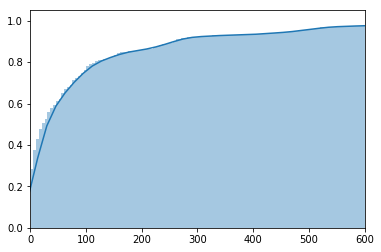

In [245]:
plt.clf()
sns.distplot(sorted(all_rep_len),bins=393,hist_kws={'cumulative':True},kde_kws={'cumulative':True})
plt.xlim(0, 600)
plt.savefig('output/Aries_REP_CDF.png',format='png',transparen=True,pad_inches=0)

/home/leoqaz12/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


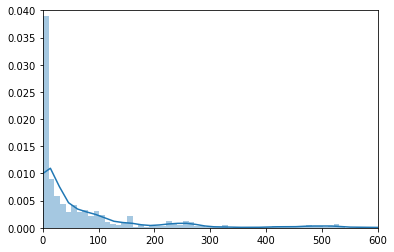

In [246]:
plt.clf()
sns.distplot(sorted(all_rep_len),bins=196,hist_kws={'cumulative':False},kde_kws={'cumulative':False})
plt.xlim(0, 600)
plt.ylim(0,0.04)
plt.savefig('output/Aries_REP_PDF.png',format='png',transparen=True,pad_inches=0)

profile analysis

In [229]:
pro_dict = dict(Counter(all_profile_len))
# print(pro_dict)
# pro_df = pd.DataFrame(pro_dict,index=['count']).T
pro_df = pd.DataFrame(data={'profile':all_profile_len})
pro_df.to_csv('output/profile_dist.csv',index=False)

In [202]:
#profile statistics
print(min(all_profile_len), max(all_profile_len), np.mean(all_profile_len), np.std(all_profile_len))
np.percentile(all_profile_len,25) , np.percentile(all_profile_len,50), np.percentile(all_profile_len,75)

1 11008 132.17893049686725 243.51364614325993


(32.0, 87.0, 116.0)

In [249]:
print(np.percentile(all_profile_len,10) , np.percentile(all_profile_len,20), np.percentile(all_profile_len,30))
print(np.percentile(all_profile_len,40) , np.percentile(all_profile_len,50), np.percentile(all_profile_len,60))
print(np.percentile(all_profile_len,70) , np.percentile(all_profile_len,80), np.percentile(all_profile_len,90))

8.0 21.0 42.0
72.0 87.0 104.0
105.0 160.0 282.0


In [303]:
print(np.percentile(all_profile_len,91.4))

324.0


/home/leoqaz12/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


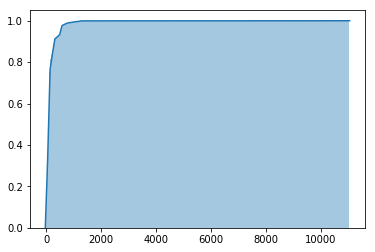

In [292]:
plt.clf()
sns.distplot(sorted(all_profile_len),bins=2202,hist_kws={'cumulative':True},kde_kws={'cumulative':True})
plt.xlim(0, 350)
# plt.savefig('output/Aries_profile_CDF.png',format='png',transparen=True,pad_inches=0)

/home/leoqaz12/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


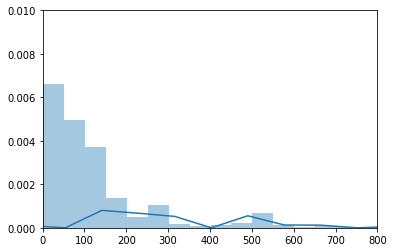

In [247]:
plt.clf()
sns.distplot(sorted(all_profile_len),bins=220,hist_kws={'cumulative':False},kde_kws={'cumulative':False})
plt.xlim(0, 800)
plt.ylim(0,0.01)
plt.savefig('output/Aries_profile_PDF.png',format='png',transparen=True,pad_inches=0)

/home/leoqaz12/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


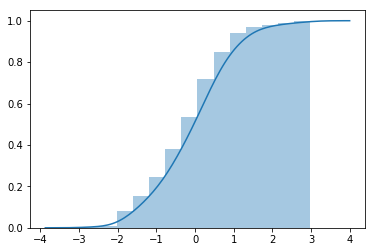

In [141]:
# x = np.random.randn(200)
# sns.distplot(x,
#              hist_kws=dict(cumulative=True),
#              kde_kws=dict(cumulative=True))

In [195]:
left_family = df[(df.Rep_len >10) & (df.Processes >2)].Family.unique().tolist()
len(left_family)

66

In [17]:
from keras.utils import to_categorical

In [7]:
import pickle
rep = pickle.load(open('./data/tree-rep-logs-profile/adload_0.8/G23/parameter_rep.pickle','rb'))
# rep_param = pickle.load(open(in_directory+'parameter_rep.pickle','rb'))
rep

EOFError: Ran out of input